## Day-ahead Energy Price Prediction using Machine Learning

### Riya Sunil Joshi
### Enrollment number: 612197

#### Importing the libraries and dependencies

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

#### The data is downloaded from the SMARD information platform. We download the data in an excel format (.xlsx extension) at an hourly interval. We use the data for forecasted energy consumption, energy generation, cross-border flow and the energy prices.

In [ ]:
consumption  = pd.read_excel('/content/Forecasted_consumption_202101010000_202501210000_Hour.xlsx')
generation  = pd.read_excel('/content/Forecasted_generation_Day-Ahead_202101010000_202501210000_Hour.xlsx')
prices  = pd.read_excel('/content/Day-ahead_prices_202101010000_202501210000_Hour.xlsx')
flow = pd.read_excel('/content/Cross-border_physical_flows_202101010000_202501210000_Hour.xlsx')

In [ ]:
consumption = consumption.drop(columns=['Residual load [MWh]'])
flow = flow[['Start date',	'End date',	'Net export [MWh]']]
prices = prices[['Start date',	'End date',	'Germany/Luxembourg [€/MWh]']]

#### Each record across the four data sources have a Start and End date. We merge the different data sources into a single data frame based on the Start Date and End Date column so that we have all the datapoints for each hour in the same dataframe.

In [ ]:
merged_df = pd.merge(consumption, generation, on=['Start date', 'End date'], how='outer')
merged_df = pd.merge(merged_df, prices, on=['Start date', 'End date'], how='outer')
merged_df = pd.merge(merged_df, flow, on=['Start date', 'End date'], how='outer')

In [ ]:
df= merged_df
df = df.drop(columns=['Net export [MWh]'])
# Convert date columns to datetime
df['Start date'] = pd.to_datetime(df['Start date'])
df['End date'] = pd.to_datetime(df['End date'])
# Set 'Start date' as the index
df.set_index('Start date', inplace=True)
df.sort_index(inplace=True)
df = df.drop(df.tail(24).index)

In [ ]:
df

End date  Total (grid load) [MWh] Total [MWh]  \
Start date                                                                     
2021-01-01 00:00:00 2021-01-01 01:00:00                 43156.25       43185   
2021-01-01 01:00:00 2021-01-01 02:00:00                 41599.25       41613   
2021-01-01 02:00:00 2021-01-01 03:00:00                 40513.50       40640   
2021-01-01 03:00:00 2021-01-01 04:00:00                 40148.00       39964   
2021-01-01 04:00:00 2021-01-01 05:00:00                 39846.75       39774   
...                                 ...                      ...         ...   
2025-01-19 19:00:00 2025-01-19 20:00:00                 56198.00       46285   
2025-01-19 20:00:00 2025-01-19 21:00:00                 54133.75       45231   
2025-01-19 21:00:00 2025-01-19 22:00:00                 52395.25       43625   
2025-01-19 22:00:00 2025-01-19 23:00:00                 51194.00       42519   
2025-01-19 23:00:00 2025-01-20 00:00:00                 48725.25       40235   

                    Photovoltaics and wind [MWh] Wind offshore [MWh]  \
Start date                                                             
2021-01-01 00:00:00                       4633.5              531.25   
2021-01-01 01:00:00                       4118.5              464.75   
2021-01-01 02:00:00                         3644                 426   
2021-01-01 03:00:00                         3266              398.25   
2021-01-01 04:00:00                         2994                 377   
...                                          ...                 ...   
2025-01-19 19:00:00                      8633.75                 227   
2025-01-19 20:00:00                         8236              261.25   
2025-01-19 21:00:00                         7692               273.5   
2025-01-19 22:00:00                         7094                 258   
2025-01-19 23:00:00                       6535.5              247.75   

                    Wind onshore [MWh] Photovoltaics [MWh] Other [MWh]  \
Start date                                                               
2021-01-01 00:00:00            4102.25                   0     38551.5   
2021-01-01 01:00:00            3653.75                   0     37494.5   
2021-01-01 02:00:00               3218                   0       36996   
2021-01-01 03:00:00            2867.75                   0       36698   
2021-01-01 04:00:00               2617                   0       36780   
...                                ...                 ...         ...   
2025-01-19 19:00:00            8406.75                   0    37651.25   
2025-01-19 20:00:00            7974.75                   0       36995   
2025-01-19 21:00:00             7418.5                   0       35933   
2025-01-19 22:00:00               6836                   0       35425   
2025-01-19 23:00:00            6287.75                   0     33699.5   

                    Germany/Luxembourg [€/MWh]  
Start date                                      
2021-01-01 00:00:00                      50.87  
2021-01-01 01:00:00                      48.19  
2021-01-01 02:00:00                      44.68  
2021-01-01 03:00:00                      42.92  
2021-01-01 04:00:00                      40.39  
...                                        ...  
2025-01-19 19:00:00                      156.6  
2025-01-19 20:00:00                     149.06  
2025-01-19 21:00:00                     139.26  
2025-01-19 22:00:00                     130.99  
2025-01-19 23:00:00                     122.94  

[35576 rows x 9 columns]

# Feature Engineering

#### We derive four additional features of the hour, day, week, and month from the Start Date or End Date of each datapoint using the DatetimeIndex attribute of pandas designed for time series data with datetime64 values. This can help the model in capturing the underlying pattern that is repeating over specific time intervals. We add these features as new columns to the dataframe

In [ ]:
# Add temporal features
df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Weekday'] = df.index.weekday
df['Month'] = df.index.month

#### As the generation and consumption of energy are highly interdependent on each other, we also perform feature aggregation to introduce the ratio of consumption to generation, as not only the individual values of generation and consumption but also the tradeoff between them might be a deciding factor for the energy prices

In [ ]:
df.replace('-', 0, inplace=True)

In [ ]:
df['ratio'] = df['Total [MWh]']/df['Total (grid load) [MWh]']

# Data Visualization

####  We use boxplots to check the distribution of outliers in the data.The box represents of the middle 50 percent of the values in the data whereas the lower and upper end of the boxplot show the 1st and the 3rd quartiles of the data respectively. The outliers in the data can thus be interpreted as the points that lie beyond the upper or lower end of the boxplots.

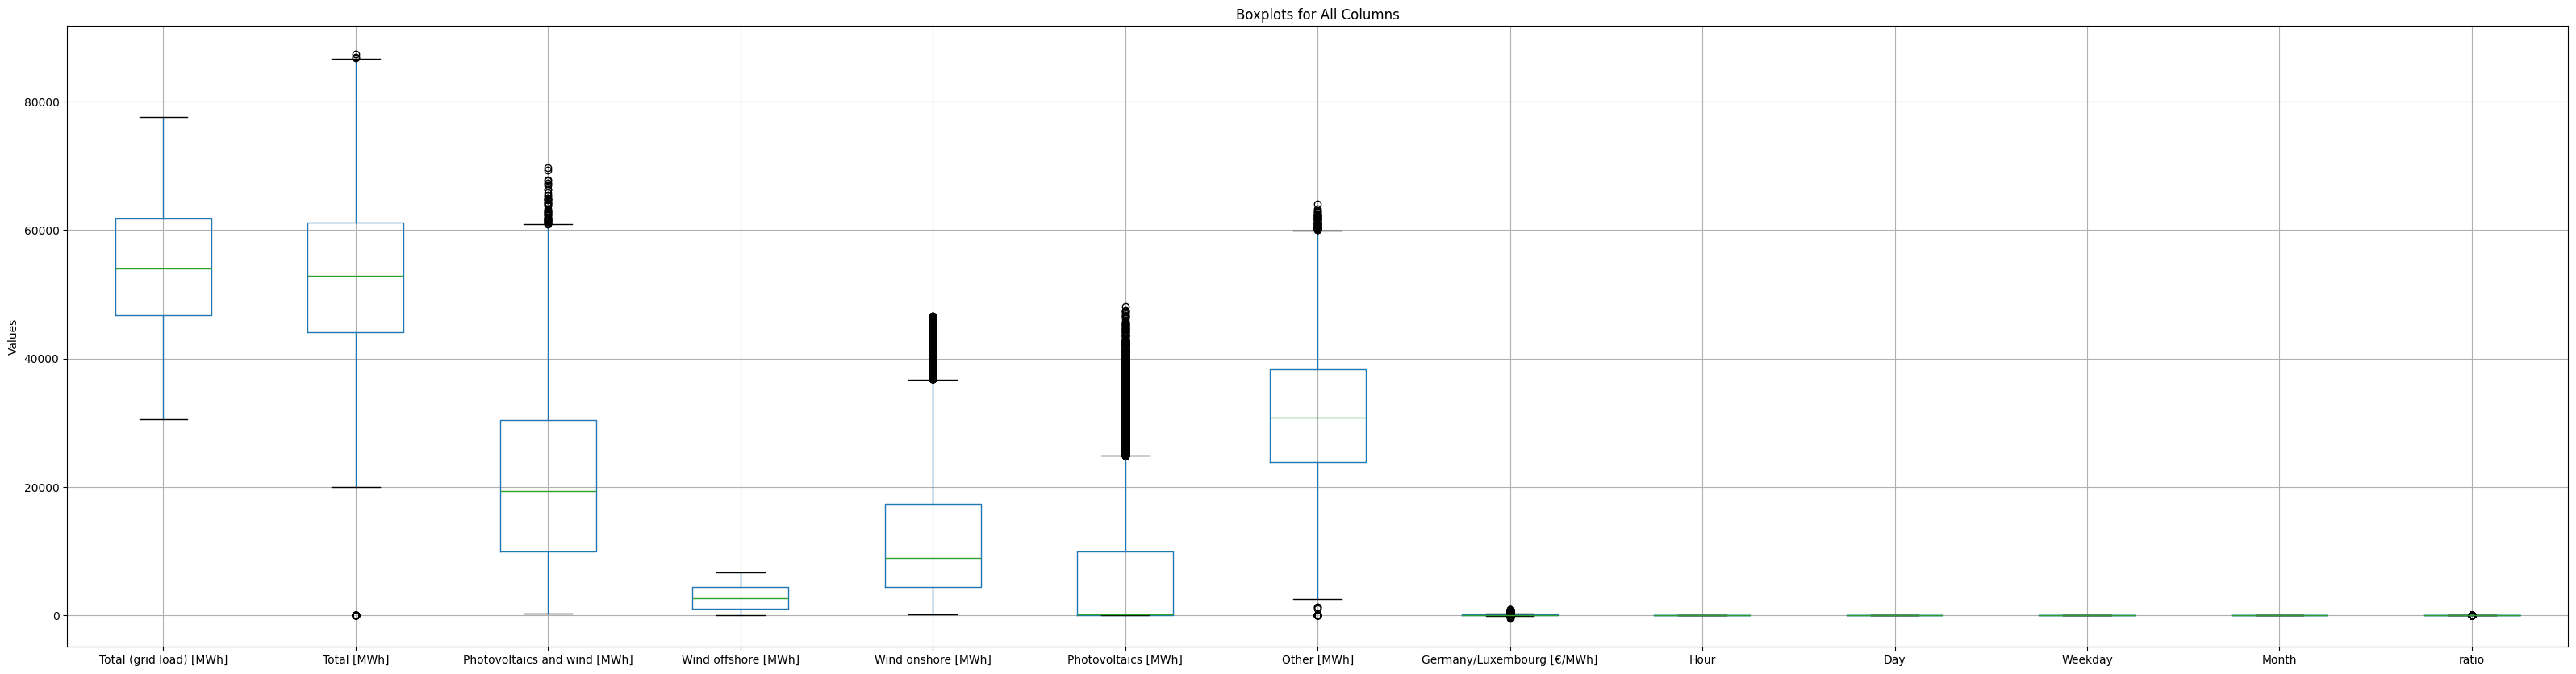

In [ ]:
# Create boxplots for all numerical columns
plt.figure(figsize=(40, 10))

df.boxplot()
plt.title("Boxplots for All Columns")
plt.ylabel("Values")

plt.show()

#### We observe that Photovoltaic and Wind Onshore particularly have many outliers.

## Line graphs

#### We analyze line graphs of the data to find patterns or trends that can be useful while building the forecasting model. We sample the data based on the average hourly, daily, weekly and monthly values based on the index which is the Start Date column.

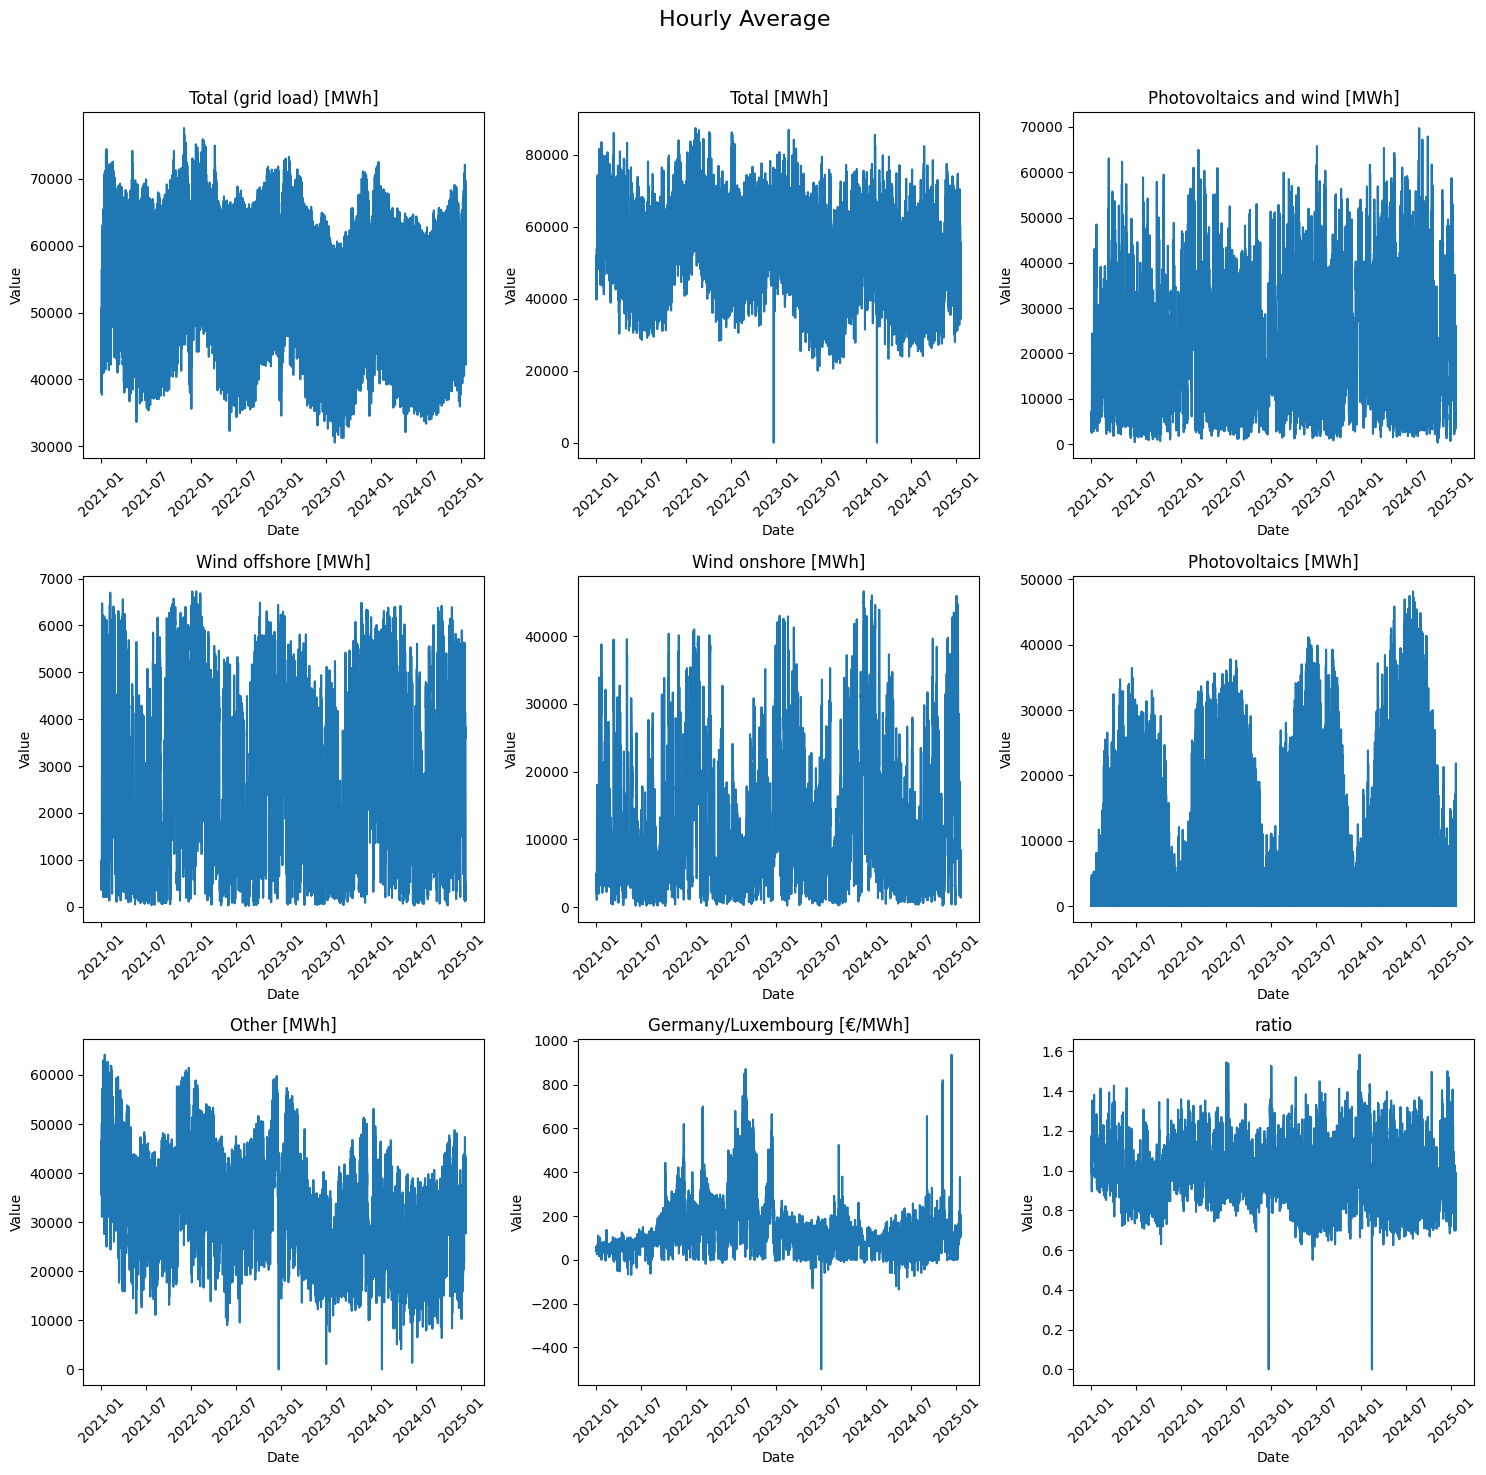

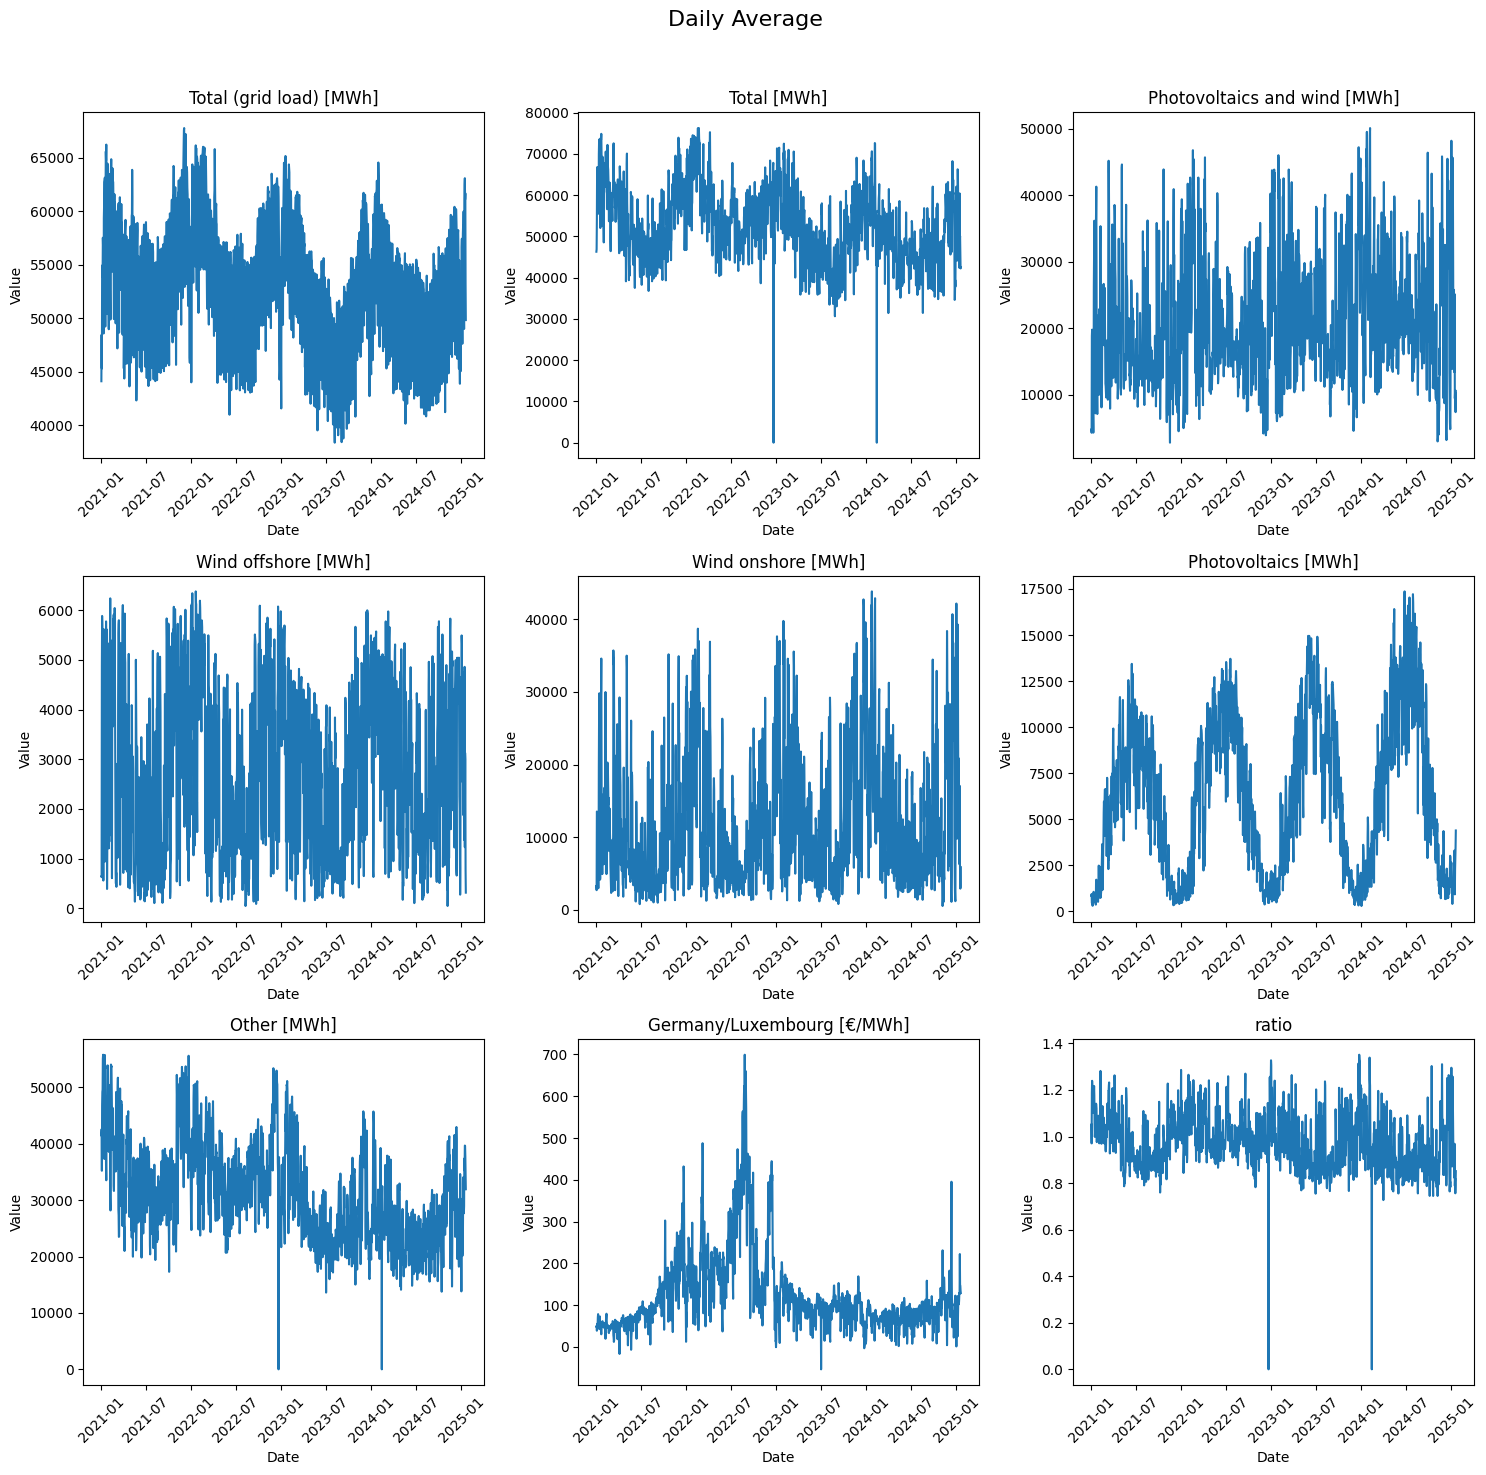

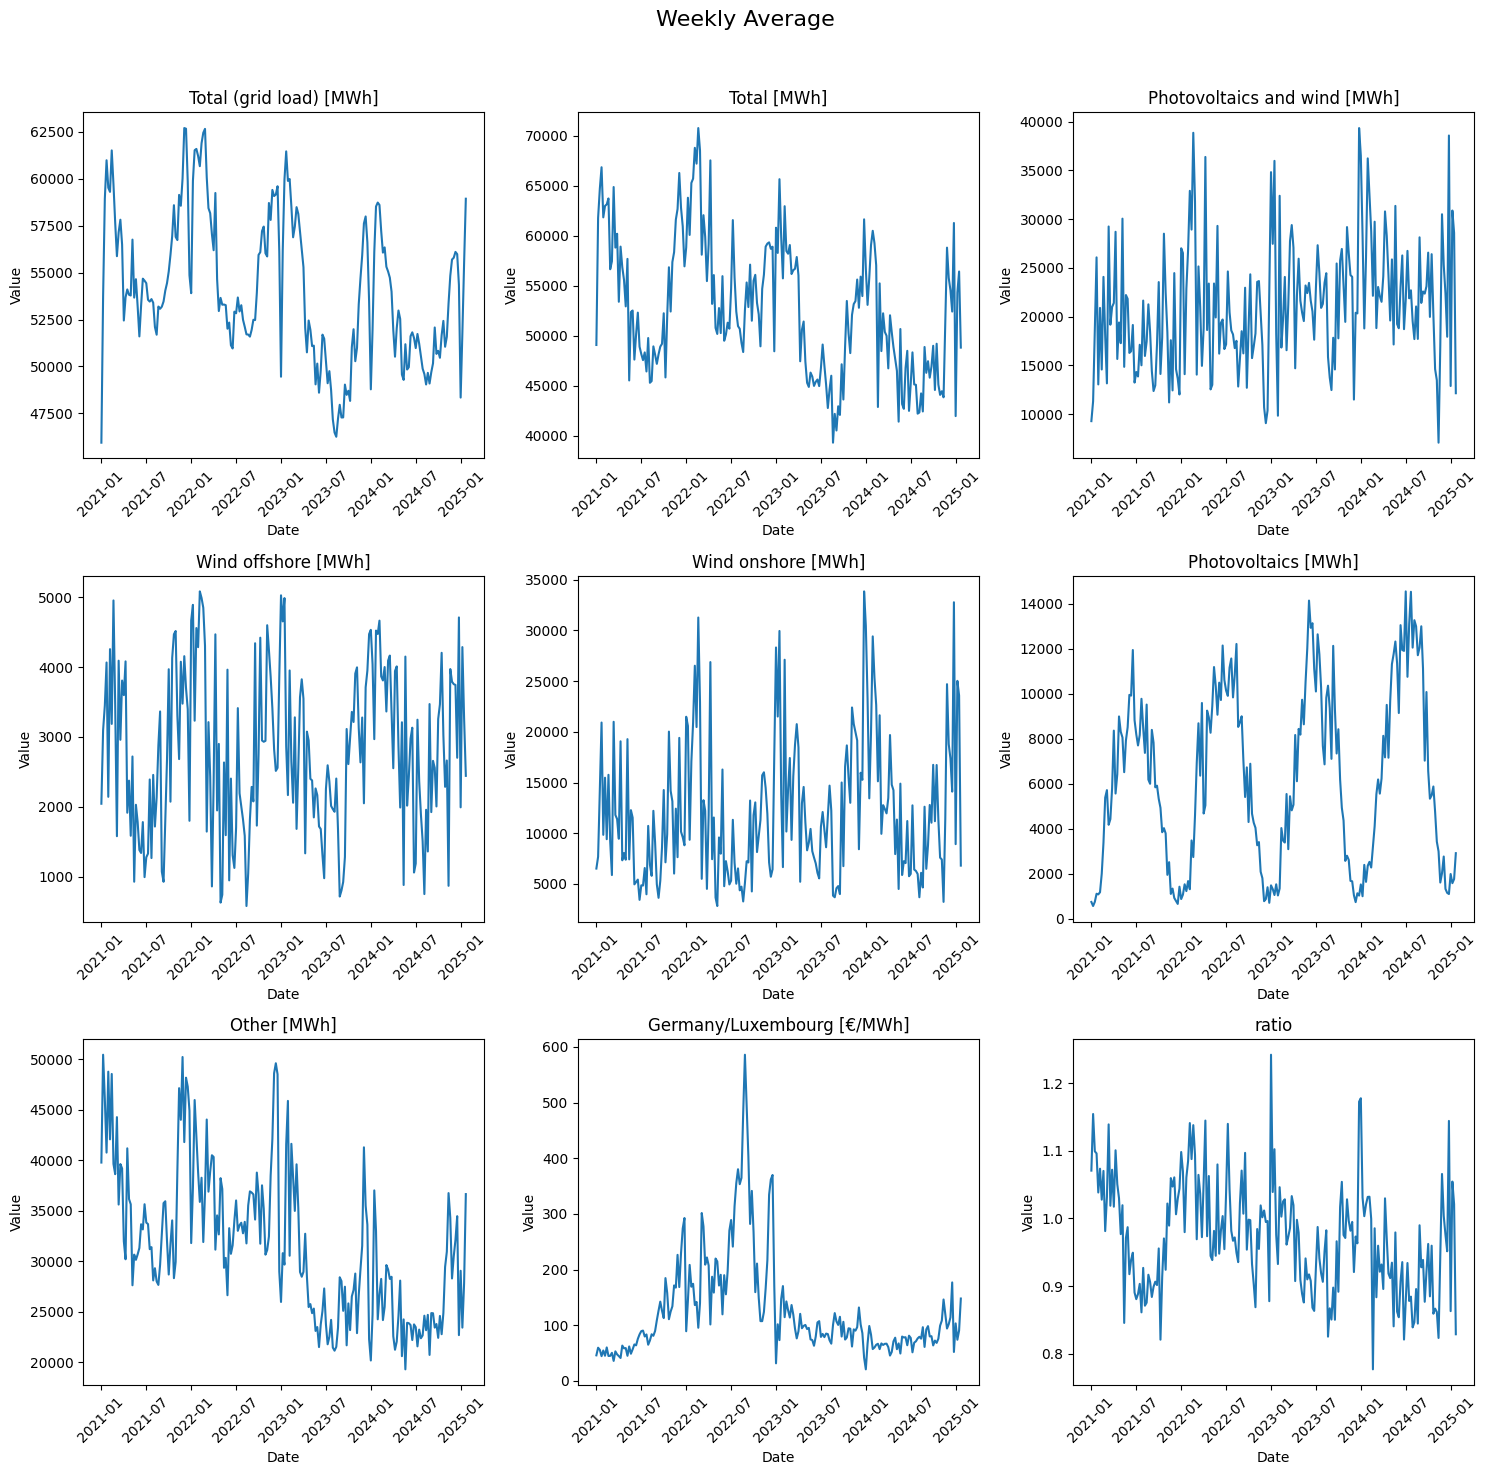

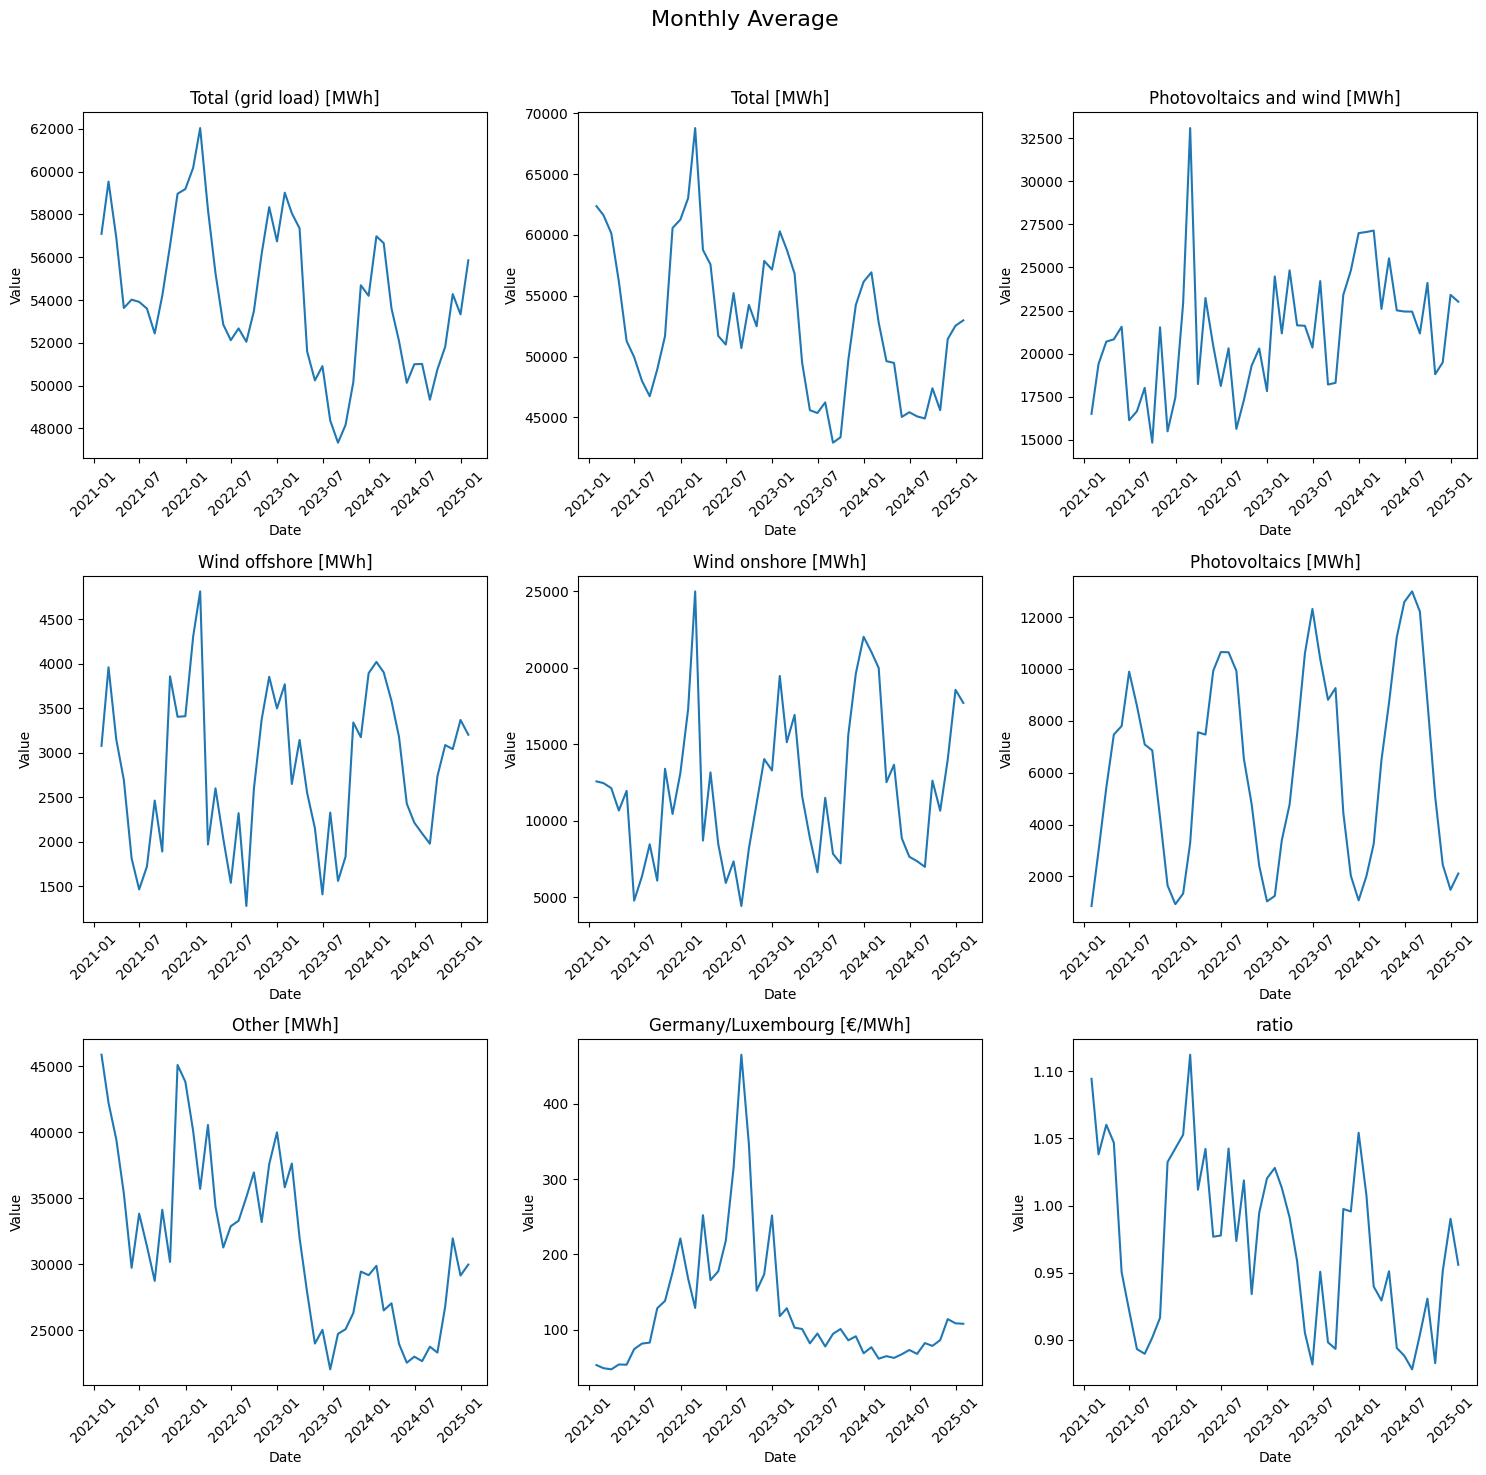

In [ ]:
import matplotlib.pyplot as plt

def plot_time_averages(df):

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

    # Calculate averages
    hourly_avg = df[numeric_cols].resample('H').mean()
    daily_avg = df[numeric_cols].resample('D').mean()
    weekly_avg = df[numeric_cols].resample('W').mean()
    monthly_avg = df[numeric_cols].resample('M').mean()

    avg_dict = {
        'Hourly Average': hourly_avg,
        'Daily Average': daily_avg,
        'Weekly Average': weekly_avg,
        'Monthly Average': monthly_avg
    }

    for avg_name, avg_df in avg_dict.items():
        num_cols = len(numeric_cols)
        num_rows = (num_cols + 2) // 3
        fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
        fig.suptitle(avg_name, fontsize=16)

        for i, col in enumerate(numeric_cols):
            row = i // 3
            col_idx = i % 3
            axes[row, col_idx].plot(avg_df.index, avg_df[col])
            axes[row, col_idx].set_title(col)
            axes[row, col_idx].set_xlabel("Date")
            axes[row, col_idx].set_ylabel("Value")
            axes[row, col_idx].tick_params(axis='x', rotation=45)

        # Remove empty subplots
        for i in range(num_cols, num_rows * 3):
            row = i // 3
            col_idx = i % 3
            fig.delaxes(axes[row, col_idx])

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

# Usage
plot_time_averages(df)

#### We observe that Wind offshore, Wind onshore, Photovoltaics, Net export, Total generation as well as the Total grid load show a repetitive pattern over daily, weekly as well as monthly averages

## Correlation Matrix

#### A correlation matrix is calculated to visualize the strength and direction of the correlation between the features and the target column. We can see that the Wind onshore, Wind offshore, and Photovoltaics have a negative correlation to the energy prices whereas the ratio of consumption and generation, and the total grid load have a positive correlation to the energy prices. However, we do not see any perfect linear relationships between the variables, which is considered while selecting the forecasting models.

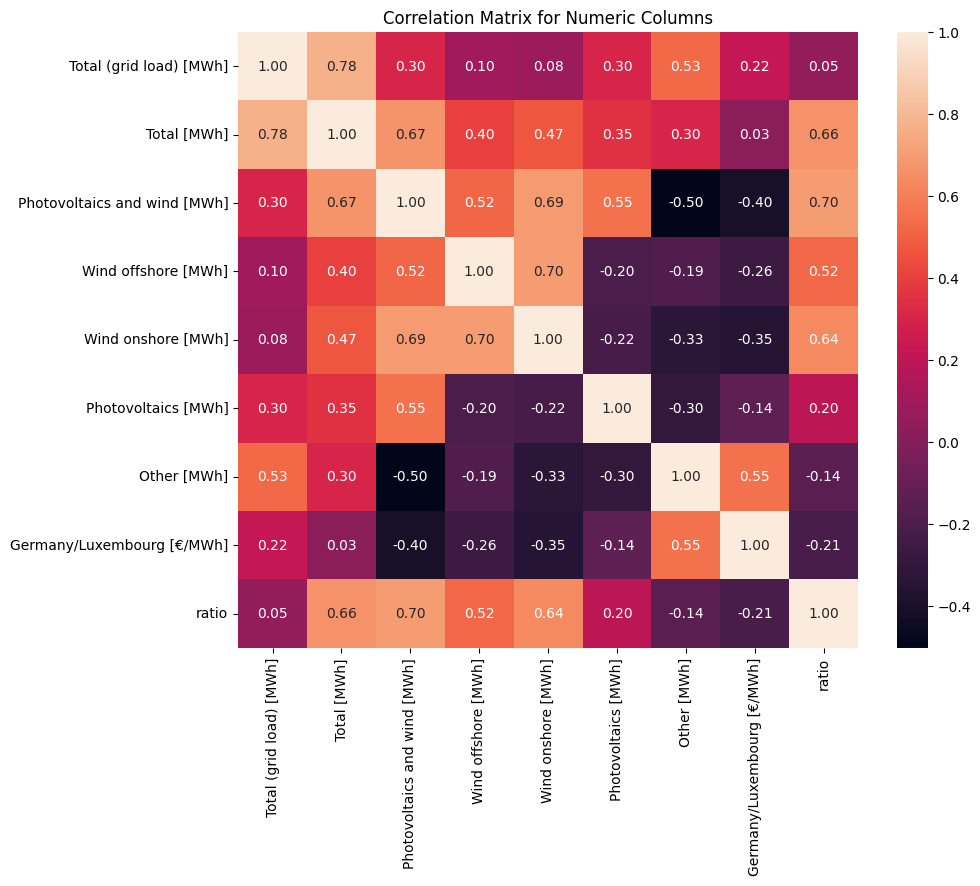

In [ ]:
# Compute correlation matrix
numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_df.corr()

# Set the figure size
plt.figure(figsize=(10, 8))

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f")

# Add title
plt.title("Correlation Matrix for Numeric Columns")

# Show the plot
plt.show()

## Pearson's correlation coefficient

#### The correlation coefficient known as the Pearson Correlation Coefficient is calculated by comparing the deviations of the two data points from their respective means, normalized by the product of their standard deviations. These are the same values that are used to calculate the correlation matrix above and help in determining the magnitude and direction of relationship between variables.

In [ ]:
from scipy.stats import pearsonr, spearmanr
target_col = "Germany/Luxembourg [€/MWh]"
correlations = {}
for col in numeric_df:
    if col != target_col:
        pearson_corr, _ = pearsonr(df[col], df[target_col])
        spearman_corr, _ = spearmanr(df[col], df[target_col])
        correlations[col] = {"Pearson": pearson_corr, "Spearman": spearman_corr}

In [ ]:
# Display correlation results
correlation_df = pd.DataFrame(correlations).T.sort_values(by="Pearson")
print("\nCorrelations with the target variable:")
print(correlation_df)


Correlations with the target variable:
                               Pearson  Spearman
Photovoltaics and wind [MWh] -0.403493 -0.481505
Wind onshore [MWh]           -0.354079 -0.381718
Wind offshore [MWh]          -0.258956 -0.282942
ratio                        -0.212035 -0.330554
Photovoltaics [MWh]          -0.135694 -0.087187
Total [MWh]                   0.029195 -0.033057
Total (grid load) [MWh]       0.222254  0.262037
Other [MWh]                   0.553624  0.646094


# Function for outlier handling

#### The part for the function call is commented out as we first want to train the model with unclean data

In [ ]:
import pandas as pd

def handle_outliers(df, numeric_columns):

    # Calculate IQR (Interquartile Range)
    q1 = df[numeric_columns].quantile(0.25)
    q3 = df[numeric_columns].quantile(0.75)
    iqr = q3 - q1

    # Check for initial outliers
    outliers = ((df[numeric_columns] < (q1 - 1.5 * iqr)) | (df[numeric_columns] > (q3 + 1.5 * iqr))).sum()
    print("Outlier Count:")
    print(outliers)

    # Capping outliers based on IQR thresholds
    for column in numeric_columns:
        lower_bound = q1[column] - 1.5 * iqr[column]
        upper_bound = q3[column] + 1.5 * iqr[column]
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    # Recheck for outliers post-processing
    updated_outliers = ((df[numeric_columns] < (q1 - 1.5 * iqr)) | (df[numeric_columns] > (q3 + 1.5 * iqr))).sum()

    return df, outliers, updated_outliers

# Usage
#numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
#df, outliers, updated_outliers = handle_outliers(df, numeric_columns)

# Print the counts
#print("Updated Outlier Count:")
#print(updated_outliers)

# Model Training

#### We have used different settings to enable comparative analysis between the results of these settings. We started by using the last 24 values of the dataset as the test data and used the rest of the data for training the model. We then retrained all the models by using 80 percent data and testing the performance of those models on 10 percent of the data. We also trained the models without performing the data preprocessing techniques discussed in Section 4, to check the impact of data cleaning on the model performance. While splitting the dataset into training and testing data, we did not shuffle the rows of the data like we do in traditional machine learning models, to preserve the temporal sequence of the data

 #### We train the CatBoost, RandomForest Regressor, Ensemble model and the GRU model with unclean data first. We use a function to create lagged features as additional input features which is initialized and called separately in every model training process. This is not automated at the start of the implementation for our convenience as we want to further use use a model where no lagged features are used as input features to evaluate the impact.  

# Forecasting Without Data Preprocessing


#### We first train the models without removing the outliers. We split the data with 80% for training and 20% for testing. We also introduce lagged features to train the model.We use the Mean Absolute Error(MAE), the Root Mean Squared Error(RMSE) an the R2 value to evaluate the results. For each model we also plot the line graph to check the last 24 predicted values that represent the day ahead predictions made by the models and compare them to the actual values.

# CatBoost

0:	learn: 109.4545538	test: 76.3031345	best: 76.3031345 (0)	total: 70.9ms	remaining: 1m 10s
100:	learn: 16.3722841	test: 19.6478861	best: 19.6478861 (100)	total: 1.57s	remaining: 13.9s
200:	learn: 14.0706132	test: 18.4991789	best: 18.4991789 (200)	total: 3.05s	remaining: 12.1s
300:	learn: 12.8826459	test: 17.8994036	best: 17.8994036 (300)	total: 6.29s	remaining: 14.6s
400:	learn: 12.1048998	test: 17.6030425	best: 17.6029710 (399)	total: 10s	remaining: 15s
500:	learn: 11.5457333	test: 17.3937233	best: 17.3937233 (500)	total: 13.5s	remaining: 13.5s
600:	learn: 11.1026294	test: 17.1757508	best: 17.1757508 (600)	total: 15.4s	remaining: 10.2s
700:	learn: 10.7223017	test: 17.0343872	best: 17.0343872 (700)	total: 17.6s	remaining: 7.52s
800:	learn: 10.3914871	test: 16.9388725	best: 16.9388725 (800)	total: 19.9s	remaining: 4.93s
900:	learn: 10.0857063	test: 16.8495481	best: 16.8495481 (900)	total: 21.3s	remaining: 2.34s
999:	learn: 9.8223122	test: 16.7355910	best: 16.7321412 (998)	total: 22.8s	

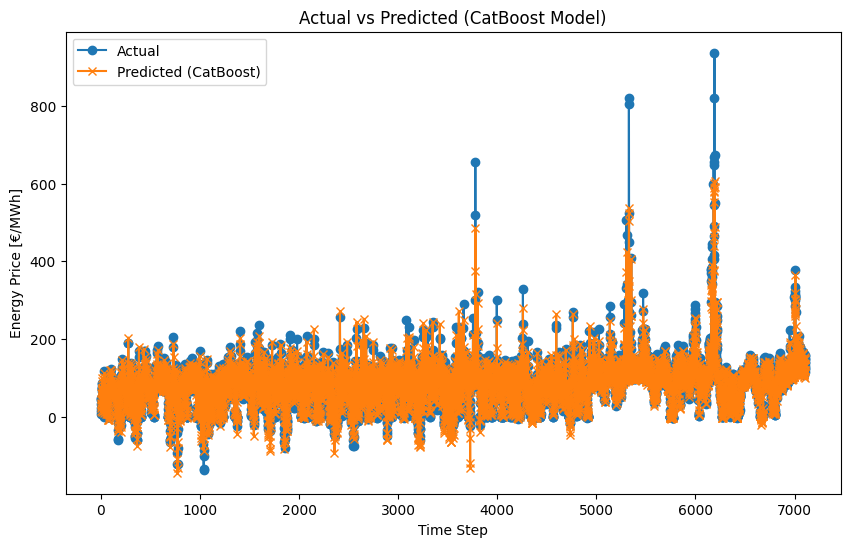

In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to create lagged features
def create_lagged_features(data, target_col, lags):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    df = df.dropna()  # Drop rows with NaN values caused by lagging
    return df

target_col = 'Germany/Luxembourg [€/MWh]'
lags = 24  # Number of lagged features
data = create_lagged_features(df, target_col, lags)

# Features and target
X = data.drop(columns=[target_col], errors='ignore')  # Drop target and date columns
y = data[target_col]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize CatBoost Regressor
catboost_model = CatBoostRegressor(
    iterations=1000,         # Number of trees
    learning_rate=0.05,      # Learning rate
    depth=6,                 # Depth of trees
    loss_function='RMSE',    # Loss function
    random_seed=42,
    verbose=100              # Print training results every 100 iterations
)

# Train the CatBoost model
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, early_stopping_rounds=100)

# Make predictions
y_pred = catboost_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nEvaluation Metrics for CatBoost Model:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual", marker="o")
plt.plot(y_pred, label="Predicted (CatBoost)", marker="x")
plt.title("Actual vs Predicted (CatBoost Model)")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

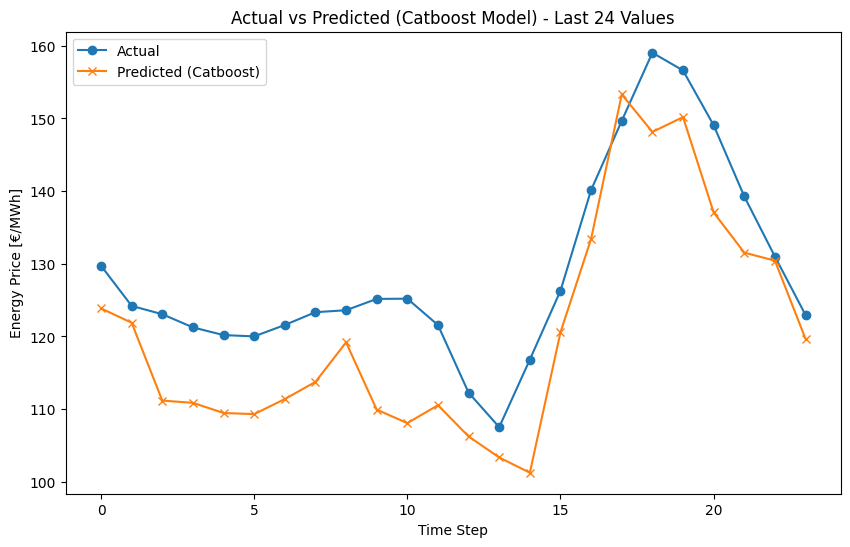

In [ ]:
# Plot predictions vs actual values for the last 24 values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[-24:], label="Actual", marker="o")
plt.plot(y_pred[-24:], label="Predicted (Catboost)", marker="x")
plt.title("Actual vs Predicted (Catboost Model) - Last 24 Values")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

## Ensemble Model


Evaluation Metrics for Ensemble Model:
Root Mean Squared Error (RMSE): 17.3952
Mean Absolute Error (MAE): 8.6652
R-squared (R²): 0.9115


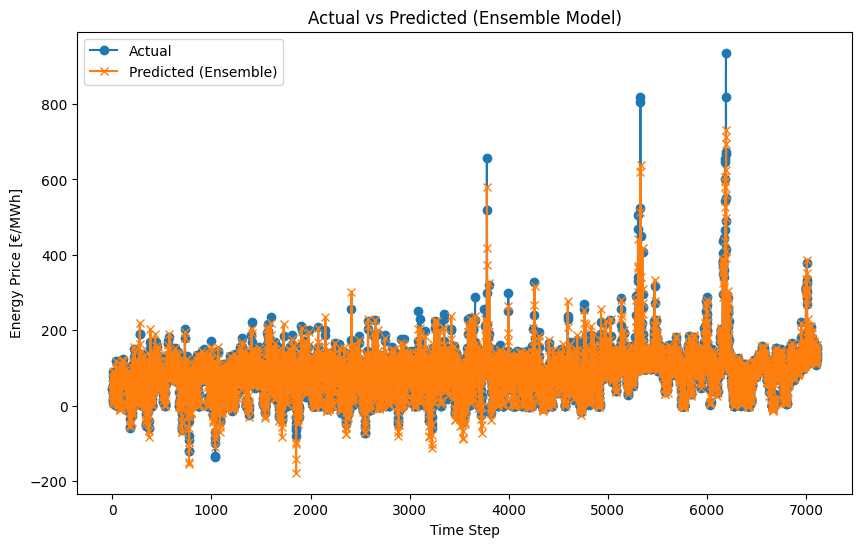

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

df.drop(columns=['End date'], inplace = True)

# Function to create lagged features
def create_lagged_features(data, target_col, lags):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    df = df.dropna()  # Drop rows with NaN values caused by lagging
    return df

# Load your dataset (assuming `df` is the DataFrame)
target_col = 'Germany/Luxembourg [€/MWh]'
lags = 24  # Number of lagged features
data = create_lagged_features(df, target_col, lags)

# Features and target
X = data.drop(columns=[target_col])  # Drop target and date columns
y = data[target_col]

X.columns = X.columns.str.replace(r"[\[\]<]", "", regex=True).str.replace(" ", "_")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize models
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)

# Train Random Forest model
rf_model.fit(X_train, y_train)
# Train XGBoost model
xgb_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# Combine predictions using a simple average (or weighted average)
ensemble_pred = (rf_pred + xgb_pred) / 2

# Evaluate the ensemble model
rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
mae = mean_absolute_error(y_test, ensemble_pred)
r2 = r2_score(y_test, ensemble_pred)

print("\nEvaluation Metrics for Ensemble Model:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual", marker="o")
plt.plot(ensemble_pred, label="Predicted (Ensemble)", marker="x")
plt.title("Actual vs Predicted (Ensemble Model)")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

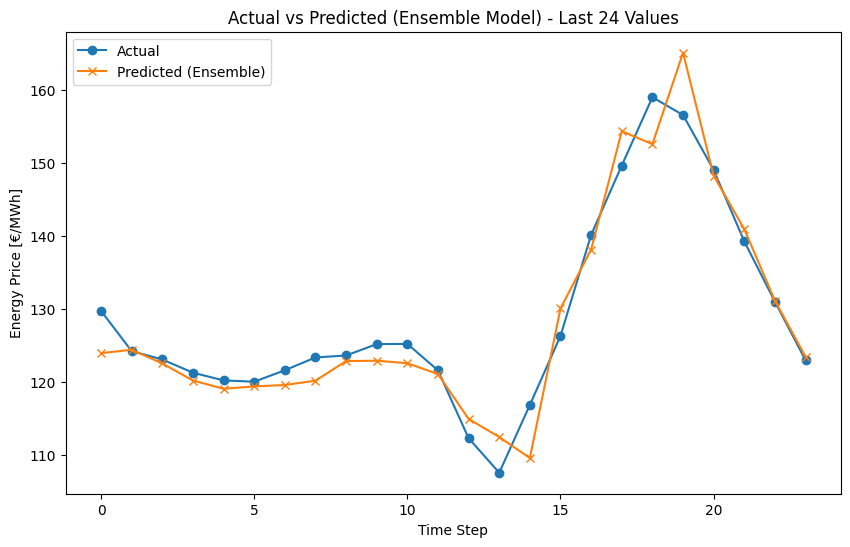

In [ ]:
# Plot predictions vs actual values for the last 24 values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[-24:], label="Actual", marker="o")
plt.plot(y_pred[-24:], label="Predicted (Ensemble)", marker="x")
plt.title("Actual vs Predicted (Ensemble Model) - Last 24 Values")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

# GRUs

Epoch 1/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - loss: 0.0026 - val_loss: 1.1373e-04
Epoch 2/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - loss: 2.0215e-04 - val_loss: 1.0520e-04
Epoch 3/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - loss: 1.9910e-04 - val_loss: 8.7325e-05
Epoch 4/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 78s 25ms/step - loss: 1.7648e-04 - val_loss: 7.9044e-05
Epoch 5/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - loss: 1.6656e-04 - val_loss: 7.6545e-05
Epoch 6/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - loss: 1.6542e-04 - val_loss: 8.9510e-05
Epoch 7/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - loss: 1.6275e-04 - val_loss: 7.5344e-05
Epoch 8/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - loss: 1.6659e-04 - val_loss: 7.3539e-05
Epoch 9/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - loss: 1.6635e-04 - val_loss: 8.3172e-05
Epoch 10/15
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 55s 27ms/step - loss: 1.5889e-04 - val_loss: 7.5206e-05
Epoch 11/15
1600/1600 ━

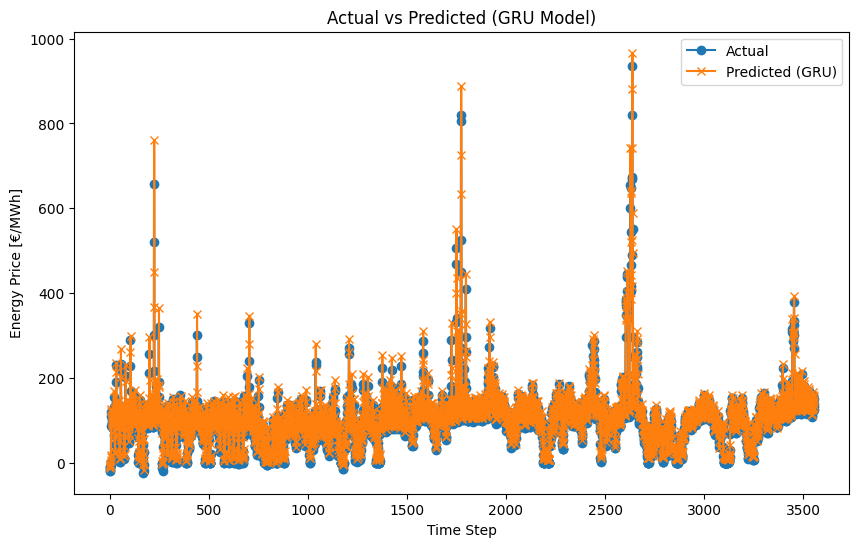

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

target_col = 'Germany/Luxembourg [€/MWh]'
data = df[[target_col]].values  # Select the target column as a numpy array

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Define sequence length
sequence_length = 24  # Use the past 24 timesteps to predict the next one

# Prepare data for GRU
def prepare_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])  # Past `sequence_length` timesteps
        y.append(data[i + sequence_length])   # The next timestep
    return np.array(X), np.array(y)

X, y = prepare_sequences(data_scaled, sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build GRU model
model = Sequential([
    GRU(64, input_shape=(sequence_length, 1), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the GRU model
history = model.fit(X_train, y_train, epochs=15, batch_size=16, validation_split=0.2, verbose=1)

# Make predictions
gru_pred = model.predict(X_test)

# Rescale predictions and actual values back to original scale
y_test_rescaled = scaler.inverse_transform(y_test)
gru_pred_rescaled = scaler.inverse_transform(gru_pred)

# Evaluate the GRU model
rmse = np.sqrt(mean_squared_error(y_test_rescaled, gru_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, gru_pred_rescaled)
r2 = r2_score(y_test_rescaled, gru_pred_rescaled)

print("\nEvaluation Metrics for GRU Model:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="Actual", marker="o")
plt.plot(gru_pred_rescaled, label="Predicted (GRU)", marker="x")
plt.title("Actual vs Predicted (GRU Model)")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

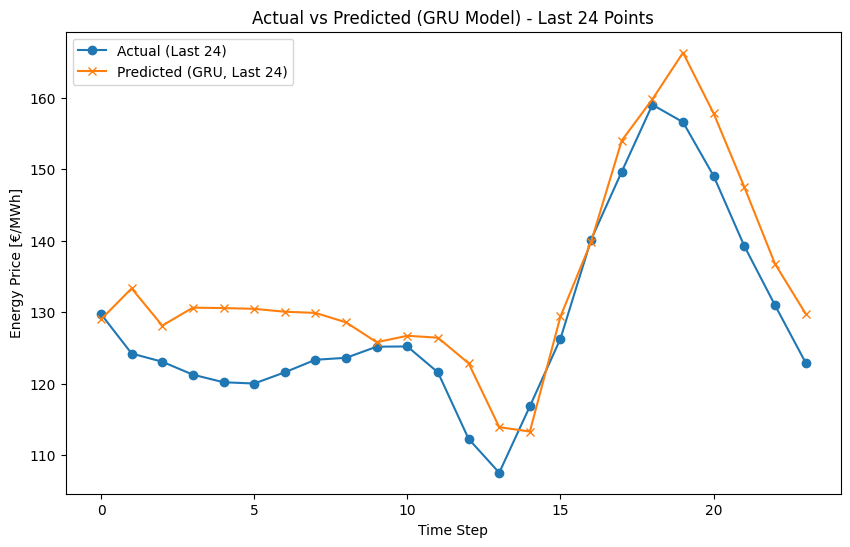

In [ ]:
# Plot predictions vs actual values for the last 24 points
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled[-24:], label="Actual (Last 24)", marker="o")
plt.plot(gru_pred_rescaled[-24:], label="Predicted (GRU, Last 24)", marker="x")
plt.title("Actual vs Predicted (GRU Model) - Last 24 Points")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

#  Random Forest Regressor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

#df['End date'] = pd.to_datetime(df['End date'])
#df.drop(columns=['End date'], inplace=True)

# Function to create lagged features
def create_lagged_features(data, target_col, lags):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    df = df.dropna()  # Drop rows with NaN values caused by lagging
    return df

# Load your dataset 
target_col = 'Germany/Luxembourg [€/MWh]'
lags = 24  # Number of lagged features
data = create_lagged_features(df, target_col, lags)

# Features and target
X = data.drop(columns=[target_col], errors='ignore')  # Drop target and date columns
y = data[target_col]

# Split the dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train a Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nEvaluation Metrics for RandomForest Model:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

mae, mse, r2

(8.799631570805795, 314.8307056501238, 0.907924666636331)

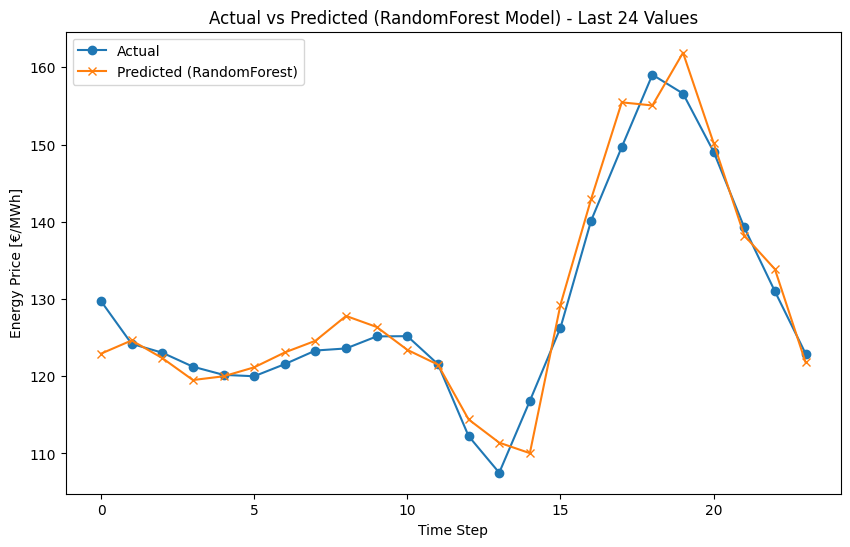

In [ ]:
# Plot predictions vs actual values for the last 24 values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[-24:], label="Actual", marker="o")
plt.plot(y_pred[-24:], label="Predicted (RandomForest)", marker="x")
plt.title("Actual vs Predicted (RandomForest Model) - Last 24 Values")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

# With Preprocessing

#### We now implement the function to remove the outliers from the model and then retrain the models with the cleaned data.

In [ ]:
import pandas as pd

def handle_outliers(df, numeric_columns):

    # Calculate IQR (Interquartile Range)
    q1 = df[numeric_columns].quantile(0.25)
    q3 = df[numeric_columns].quantile(0.75)
    iqr = q3 - q1

    # Check for initial outliers
    outliers = ((df[numeric_columns] < (q1 - 1.5 * iqr)) | (df[numeric_columns] > (q3 + 1.5 * iqr))).sum()
    print("Outlier Count:")
    print(outliers)

    # Capping outliers based on IQR thresholds
    for column in numeric_columns:
        lower_bound = q1[column] - 1.5 * iqr[column]
        upper_bound = q3[column] + 1.5 * iqr[column]
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    # Recheck for outliers post-processing
    updated_outliers = ((df[numeric_columns] < (q1 - 1.5 * iqr)) | (df[numeric_columns] > (q3 + 1.5 * iqr))).sum()

    return df, outliers, updated_outliers

# Outlier Handling
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df, outliers, updated_outliers = handle_outliers(df, numeric_columns)

# Print the counts
print("Updated Outlier Count:")
print(updated_outliers)

In [ ]:
# Outlier handling: Capping extreme values based on IQR thresholds manual method

""" 
for column in numeric_columns:
    lower_bound = q1[column] - 1.5 * iqr[column]
    upper_bound = q3[column] + 1.5 * iqr[column]
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

# Recheck for outliers post-processing
updated_outliers = ((df[numeric_columns] < (q1 - 1.5 * iqr)) | (df[numeric_columns] > (q3 + 1.5 * iqr))).sum()
updated_outliers
"""

Total (grid load) [MWh]         0
Total [MWh]                     0
Photovoltaics and wind [MWh]    0
Wind offshore [MWh]             0
Wind onshore [MWh]              0
Photovoltaics [MWh]             0
Other [MWh]                     0
Germany/Luxembourg [€/MWh]      0
ratio                           0
dtype: int64

# Random Forest Regressor

#### We perform hyperparameter tuning for a Random Forest Regressor using RandomizedSearchCV combined with feature selection. The FeatureSelector class selects the top N most important features based on feature importance from a Random Forest model. The RandomizedSearchCV is used to find the best combination of hyperparameters (top_n, n_estimators, max_depth) through randomized search, optimizing the model using the neg_mean_absolute_error metric.

#### After performing the randomized search, the best model is selected based on the mean absolute error (MAE). The results are displayed in a sorted table, showing the combination of parameters and their corresponding MAE.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Function to create lagged features
def create_lagged_features(data, target_col, lags):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    df = df.dropna()  # Drop rows with NaN values caused by lagging
    return df

# Load your dataset
target_col = 'Germany/Luxembourg [€/MWh]'
lags = 24  # Number of lagged features
data = create_lagged_features(df, target_col, lags)

# Features and target
X = data.drop(columns=[target_col], errors='ignore')  # Drop target column
y = data[target_col]

# Split the dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


class FeatureSelector(BaseEstimator, TransformerMixin):
    """Selects the top N most important features using RandomForestRegressor."""
    def __init__(self, top_n=10):
        self.top_n = top_n
        self.selected_features = None

    def fit(self, X, y):
        model = RandomForestRegressor(n_estimators=50, random_state=42)
        model.fit(X, y)
        feature_importances = model.feature_importances_
        sorted_idx = np.argsort(feature_importances)[::-1]  # Sort in descending order
        self.selected_features = X.columns[sorted_idx[:self.top_n]]
        return self

    def transform(self, X):
        return X[self.selected_features]

# Pipeline with Feature Selection and Random Forest
pipeline = Pipeline([
    ('feature_selection', FeatureSelector(top_n=10)),  # Selects top N features
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define Parameter Grid for Randomized Search
param_dist = {
    'feature_selection__top_n': [5, 10],  # Different numbers of top features
    'regressor__n_estimators': [100, 200, 300],  # Random values for n_estimators
    'regressor__max_depth': [5, 10, 15]  # Maximum depth of trees
}

# Perform Randomized Search
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                                   n_iter=5, cv=3, scoring='neg_mean_absolute_error',
                                   n_jobs=-1, verbose=1, random_state=42)

# Fit the Randomized Search
random_search.fit(X_train, y_train)

# Print All Results
results_df = pd.DataFrame(random_search.cv_results_)

# Convert negative MAE to positive for readability
results_df['mean_test_score'] = -results_df['mean_test_score']

# Select relevant columns
results_df = results_df[['param_feature_selection__top_n',
                         'param_regressor__n_estimators',
                         'param_regressor__max_depth',
                         'mean_test_score',
                         'std_test_score',
                         'rank_test_score']]

# Rename columns for clarity
results_df.rename(columns={'mean_test_score': 'Mean Absolute Error (MAE)',
                           'std_test_score': 'Std Dev (MAE)',
                           'rank_test_score': 'Rank'}, inplace=True)

# Sort by rank (best performance first)
results_df = results_df.sort_values(by='Rank')

# Print results
print("===== Randomized Search Results =====")
print(results_df)

# Print best parameters and best score
print("\nBest Parameters:", random_search.best_params_)
print("Best MAE:", -random_search.best_score_)




Fitting 3 folds for each of 5 candidates, totalling 15 fits
===== Randomized Search Results =====
   param_feature_selection__top_n  param_regressor__n_estimators  \
2                               5                            300   
3                               5                            300   
4                               5                            100   
1                               5                            200   
0                               5                            100   

   param_regressor__max_depth  Mean Absolute Error (MAE)  Std Dev (MAE)  Rank  
2                          15                   8.002254       1.518405     1  
3                          10                   8.099328       1.521789     2  
4                          10                   8.119822       1.524886     3  
1                           5                  10.316588       1.524423     4  
0                           5                  10.340800       1.524809     5  

Best Paramet

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Use the best estimator from RandomizedSearchCV to make predictions
y_pred = random_search.best_estimator_.predict(X_test)

# Calculate R², MAE, and RMSE for the test set
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the metrics
print(f"R²: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


R²: 0.9196
Mean Absolute Error (MAE): 8.8214
Root Mean Squared Error (RMSE): 14.2017


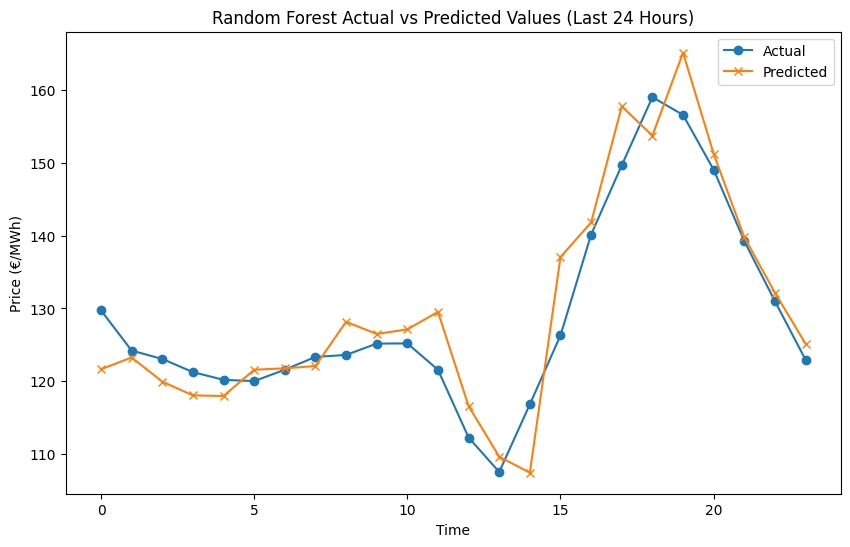

In [ ]:
# Make predictions for the test set
#y_pred = random_search.best_estimator_.predict(X_test)

# Get the last 24 hours of actual and predicted values
last_24_actual = y_test[-24:]
last_24_predicted = y_pred[-24:]

# Plot actual vs predicted values for the last 24 hours
plt.figure(figsize=(10, 6))
plt.plot(last_24_actual.values[-24:], label='Actual', marker='o')
plt.plot(last_24_predicted, label='Predicted', marker='x')
plt.title('Random Forest Actual vs Predicted Values (Last 24 Hours)')
plt.xlabel('Time')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.show()


# CatBoost

#### This code implements a time series forecasting model using CatBoostRegressor. A GridSearchCV is used to perform hyperparameter tuning on the CatBoost model, optimizing parameters like the number of iterations, depth of trees, and L2 regularization. After fitting the model, the best parameters are retrieved, and performance is evaluated using metrics like Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R²). Finally, it plots the actual vs predicted energy prices to visually assess the model's performance.


Best Parameters from Grid Search:
{'depth': 4, 'iterations': 1000, 'l2_leaf_reg': 5}

Evaluation Metrics for Best CatBoost Model:
Root Mean Squared Error (RMSE): 12.7697
Mean Absolute Error (MAE): 7.8985
R-squared (R²): 0.9350


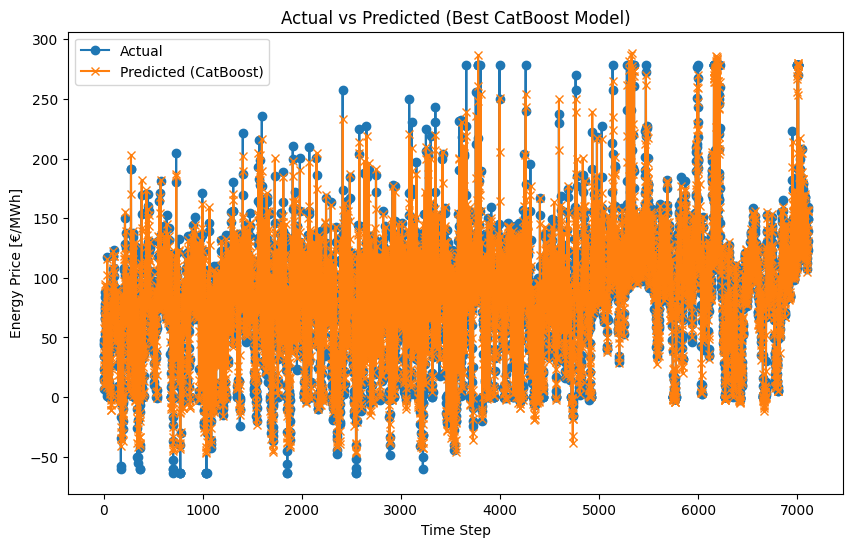

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to create lagged features
def create_lagged_features(data, target_col, lags):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    df = df.dropna()
    return df

# Load dataset
target_col = 'Germany/Luxembourg [€/MWh]'
lags = 24

data = create_lagged_features(df, target_col, lags)

# Features and target
X = data.drop(columns=[target_col], errors='ignore')
y = data[target_col]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define parameter grid
param_grid = {
    'iterations': [500, 1000],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
}

# Initialize CatBoost Regressor
catboost_model = CatBoostRegressor(random_seed=42, verbose=0)

# Grid Search
grid_search = GridSearchCV(catboost_model, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nBest Parameters from Grid Search:")
print(grid_search.best_params_)
print("\nEvaluation Metrics for Best CatBoost Model:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual", marker="o")
plt.plot(y_pred, label="Predicted (CatBoost)", marker="x")
plt.title("Actual vs Predicted (Best CatBoost Model)")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

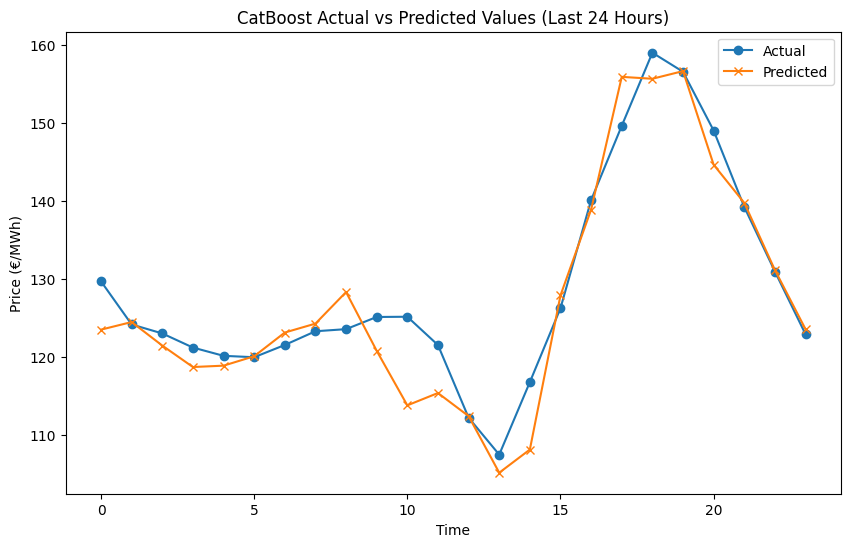

In [ ]:
# Get the last 24 hours of actual and predicted values
last_24_actual = y_test[-24:]
last_24_predicted = y_pred[-24:]

# Plot actual vs predicted values for the last 24 hours
plt.figure(figsize=(10, 6))
plt.plot(last_24_actual.values[-24:], label='Actual', marker='o')
plt.plot(last_24_predicted, label='Predicted', marker='x')
plt.title('CatBoost Actual vs Predicted Values (Last 24 Hours)')
plt.xlabel('Time')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.show()

# Ensemble Model

#### This code implements an ensemble model for time series forecasting by combining the predictions of two different models: RandomForestRegressor and XGBRegressor. Two models are trained on the training data. The predictions from both models are averaged to create an ensemble prediction. The model’s performance is evaluated using Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R²).


Evaluation Metrics for Ensemble Model:
Root Mean Squared Error (RMSE): 12.1423
Mean Absolute Error (MAE): 7.4672
R-squared (R²): 0.9413


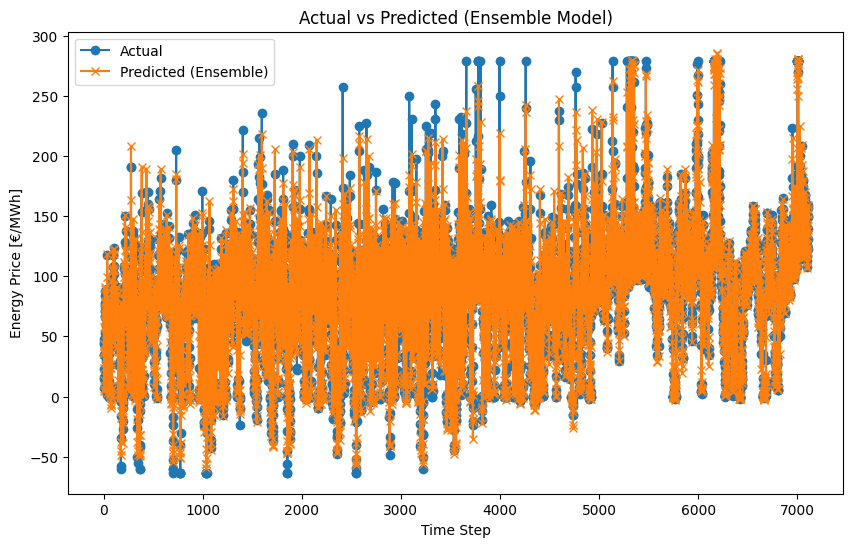

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Function to create lagged features
def create_lagged_features(data, target_col, lags):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    df = df.dropna()  # Drop rows with NaN values caused by lagging
    return df

# Load your dataset
target_col = 'Germany/Luxembourg [€/MWh]'
lags = 24  # Number of lagged features
data = create_lagged_features(df, target_col, lags)

# Features and target
X = data.drop(columns=[target_col])  # Drop target and date columns
y = data[target_col]

X.columns = X.columns.str.replace(r"[\[\]<]", "", regex=True).str.replace(" ", "_")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize models
rf_model = RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42)
xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)

# Train Random Forest model
rf_model.fit(X_train, y_train)
# Train XGBoost model
xgb_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# Combine predictions using a simple average
ensemble_pred = (rf_pred + xgb_pred) / 2

# Evaluate the ensemble model
rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
mae = mean_absolute_error(y_test, ensemble_pred)
r2 = r2_score(y_test, ensemble_pred)

print("\nEvaluation Metrics for Ensemble Model:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual", marker="o")
plt.plot(ensemble_pred, label="Predicted (Ensemble)", marker="x")
plt.title("Actual vs Predicted (Ensemble Model)")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

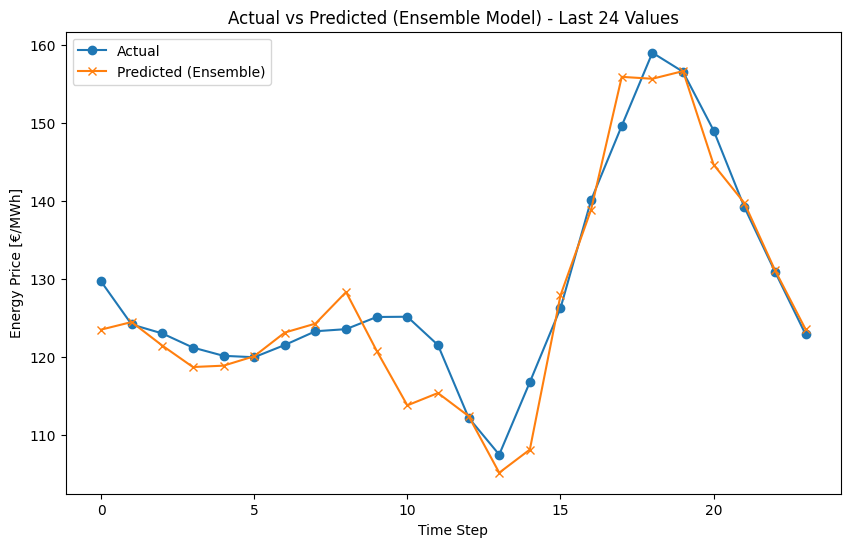

In [ ]:
# Plot predictions vs actual values for the last 24 values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[-24:], label="Actual", marker="o")
plt.plot(y_pred[-24:], label="Predicted (Ensemble)", marker="x")
plt.title("Actual vs Predicted (Ensemble Model) - Last 24 Values")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

# GRU

#### A GRU-based neural network is built with 64 units in the GRU layer, followed by a dense layer with 32 units. The final layer outputs a single value, predicting the energy price. The model is compiled with the Adam optimizer and mean squared error (MSE) as the loss function.

#### The target variable (energy prices) is scaled using MinMaxScaler to normalize the values to a range between 0 and 1. This is necessary for better convergence when training deep learning models. The function prepare_sequences() is used to create sequences of past values (24 time steps) to predict the next value. This is similar to the lagged features

#### The model is trained for 15 epochs with a batch size of 16, using 80% of the data for training and 20% for validation.The model’s predictions are evaluated using Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R²). These metrics assess the model’s accuracy in predicting the energy prices.The predictions are then rescaled back to the original price scale using the inverse transformation of the MinMaxScaler.

Epoch 1/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - loss: 0.0109 - val_loss: 0.0015
Epoch 2/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 3/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 4/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 5/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 6/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 7/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 9/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 11/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 12

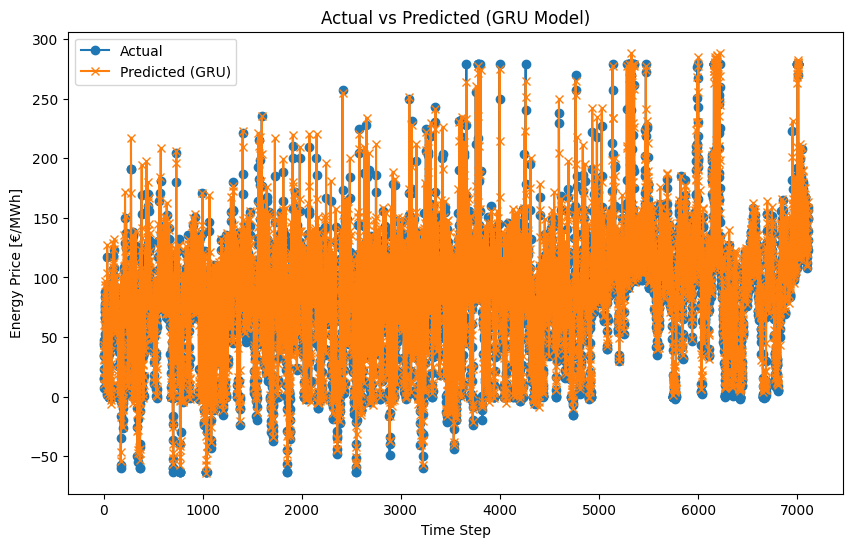

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

# Load the dataset
target_col = 'Germany/Luxembourg [€/MWh]'
data = df[[target_col]].values  # Select the target column as a numpy array

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Define sequence length
sequence_length = 24  # Use the past 24 timesteps to predict the next one

# Prepare data for GRU
def prepare_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])  # Past `sequence_length` timesteps
        y.append(data[i + sequence_length])   # The next timestep
    return np.array(X), np.array(y)

X, y = prepare_sequences(data_scaled, sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build GRU model
model = Sequential([
    GRU(64, input_shape=(sequence_length, 1), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the GRU model
history = model.fit(X_train, y_train, epochs=15, batch_size=16, validation_split=0.2, verbose=1)

# Make predictions
gru_pred = model.predict(X_test)

# Rescale predictions and actual values back to original scale
y_test_rescaled = scaler.inverse_transform(y_test)
gru_pred_rescaled = scaler.inverse_transform(gru_pred)

# Evaluate the GRU model
rmse = np.sqrt(mean_squared_error(y_test_rescaled, gru_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, gru_pred_rescaled)
r2 = r2_score(y_test_rescaled, gru_pred_rescaled)

print("\nEvaluation Metrics for GRU Model:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="Actual", marker="o")
plt.plot(gru_pred_rescaled, label="Predicted (GRU)", marker="x")
plt.title("Actual vs Predicted (GRU Model)")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

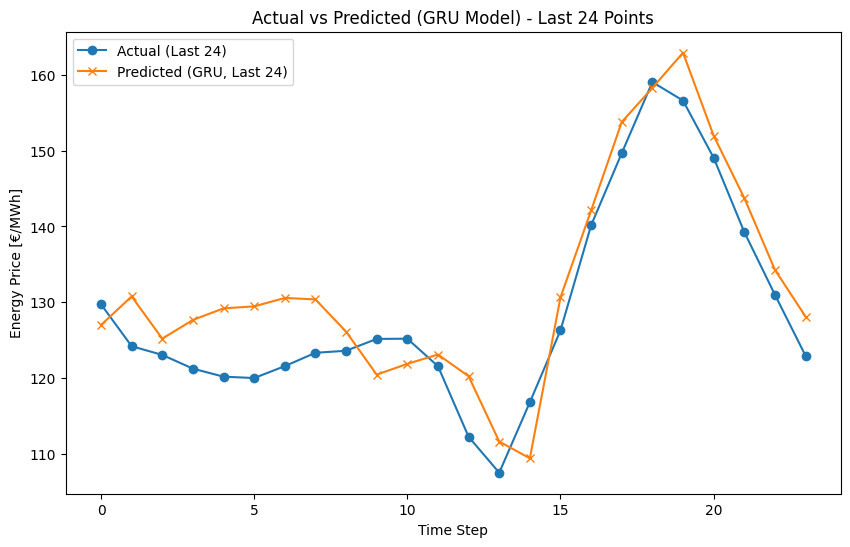

In [ ]:
# Plot predictions vs actual values for the last 24 points
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled[-24:], label="Actual (Last 24)", marker="o")
plt.plot(gru_pred_rescaled[-24:], label="Predicted (GRU, Last 24)", marker="x")
plt.title("Actual vs Predicted (GRU Model) - Last 24 Points")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

## Comparison of Results with and without Data Cleaning

#### 1. GRU is affected the most by unclean data with the highest RMSE value of 23.203, which significantly drops to 14.922 with a noticeable improvement in the R2 score. This indicates that deep learning models are more sensitive to noisy data compared to tree-based models.

#### 2. We see that the predictions of RFR are quite close to the actual values in both the cases,which proves that RFR are the least affected by unclean data.

#### 3. CatBoost and the Ensemble models show better improvements with data cleaning and perform better than RFR, which also tells us that RFR is robust against noisy data, but lacks error correction unlike CatBoost and XGBoost.

#### 4. When RFR is combined with XGBoost in the Ensemble model, the RMSE and MAE values are lower due to better error correction by the XGBoost model.

#### 5. A general trend is that all the models have higher MAE and RMSE values when trained with unclean data, whereas the errors are reduced and the R2 score slightly increases when using clean data and optimal parameters. From this, we can infer that noisy data and outliers can hinder the model performance and make the predictions worse, making data cleaning and hyperparameter tuning important steps in the model training pipeline.

# Without lagged features

#### We have implemented the same model training steps without including the lagged features as inputs.

# CatBoost

0:	learn: 76.7807731	test: 53.8715567	best: 53.8715567 (0)	total: 7.91ms	remaining: 7.9s
100:	learn: 48.0317204	test: 29.3872266	best: 29.3872266 (100)	total: 497ms	remaining: 4.42s
200:	learn: 45.4364230	test: 28.5806354	best: 28.5067577 (171)	total: 1.02s	remaining: 4.07s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 28.50675768
bestIteration = 171

Shrink model to first 172 iterations.

Evaluation Metrics for CatBoost Model:
Root Mean Squared Error (RMSE): 28.5068
Mean Absolute Error (MAE): 21.7778
R-squared (R²): 0.6887


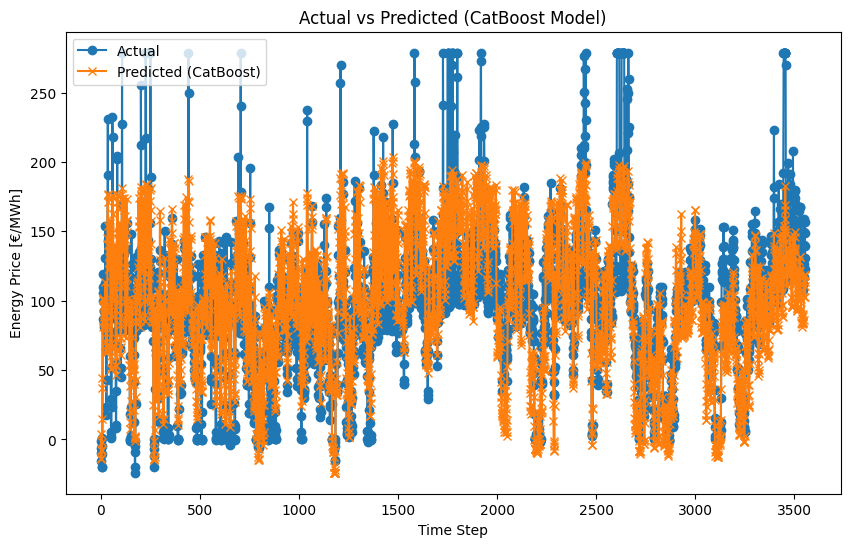

In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Features and target
X = df.drop(columns=[target_col], errors='ignore')  # Drop target and date columns
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize CatBoost Regressor
catboost_model = CatBoostRegressor(
    iterations=1000,         # Number of boosting iterations
    learning_rate=0.05,      # Learning rate
    depth=4,                 # Depth of trees
    loss_function='RMSE',    # Loss function
    random_seed=42,
    verbose=100              # Print training progress every 100 iterations
)

# Train the CatBoost model
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, early_stopping_rounds=100)

# Make predictions
y_pred = catboost_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nEvaluation Metrics for CatBoost Model:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual", marker="o")
plt.plot(y_pred, label="Predicted (CatBoost)", marker="x")
plt.title("Actual vs Predicted (CatBoost Model)")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

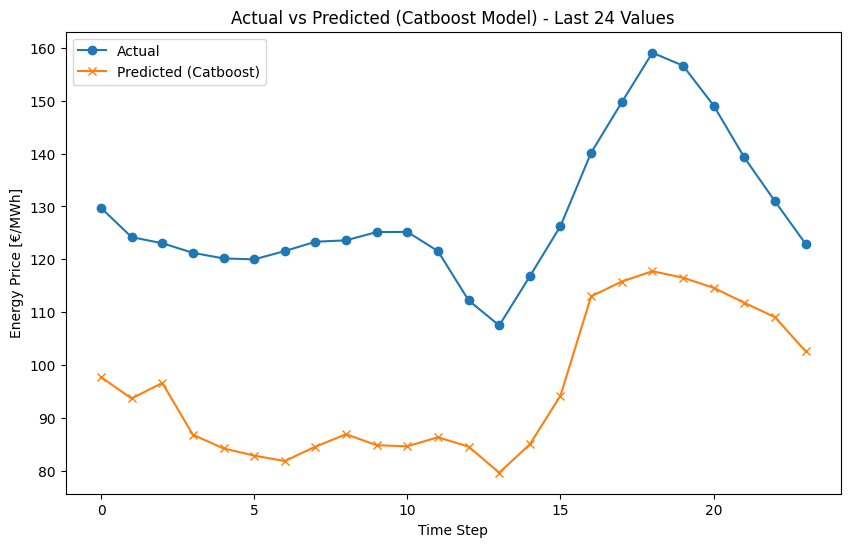

In [ ]:
# Plot predictions vs actual values for the last 24 values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[-24:], label="Actual", marker="o")
plt.plot(y_pred[-24:], label="Predicted (Catboost)", marker="x")
plt.title("Actual vs Predicted (Catboost Model) - Last 24 Values")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

# Ensemble Model


Evaluation Metrics for Ensemble Model:
Root Mean Squared Error (RMSE): 27.9607
Mean Absolute Error (MAE): 19.3433
R-squared (R²): 0.7005


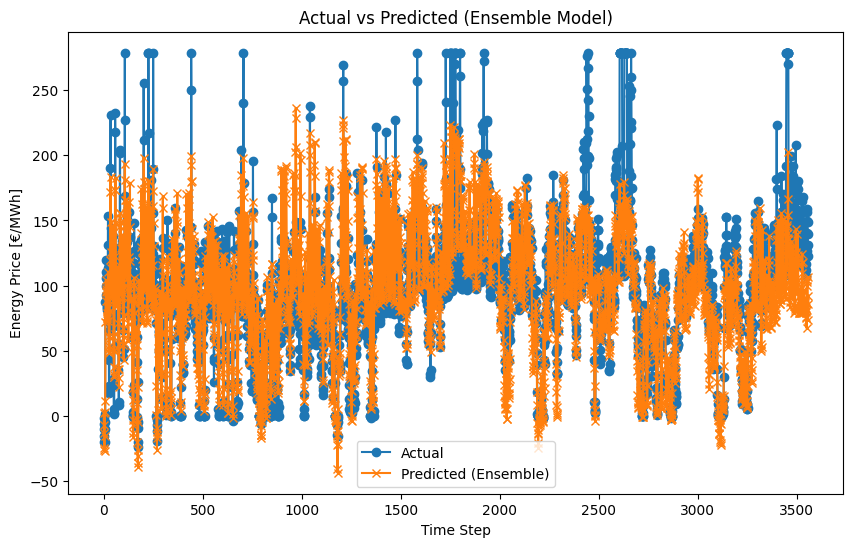

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Features and target
X = df.drop(columns=[target_col])  # Drop target and date columns
y = df[target_col]

X.columns = X.columns.str.replace(r"[\[\]<]", "", regex=True).str.replace(" ", "_")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize models
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)

# Train Random Forest model
rf_model.fit(X_train, y_train)
# Train XGBoost model
xgb_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# Combine predictions using a simple average (or weighted average)
ensemble_pred = (rf_pred + xgb_pred) / 2

# Evaluate the ensemble model
rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
mae = mean_absolute_error(y_test, ensemble_pred)
r2 = r2_score(y_test, ensemble_pred)

print("\nEvaluation Metrics for Ensemble Model:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual", marker="o")
plt.plot(ensemble_pred, label="Predicted (Ensemble)", marker="x")
plt.title("Actual vs Predicted (Ensemble Model)")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

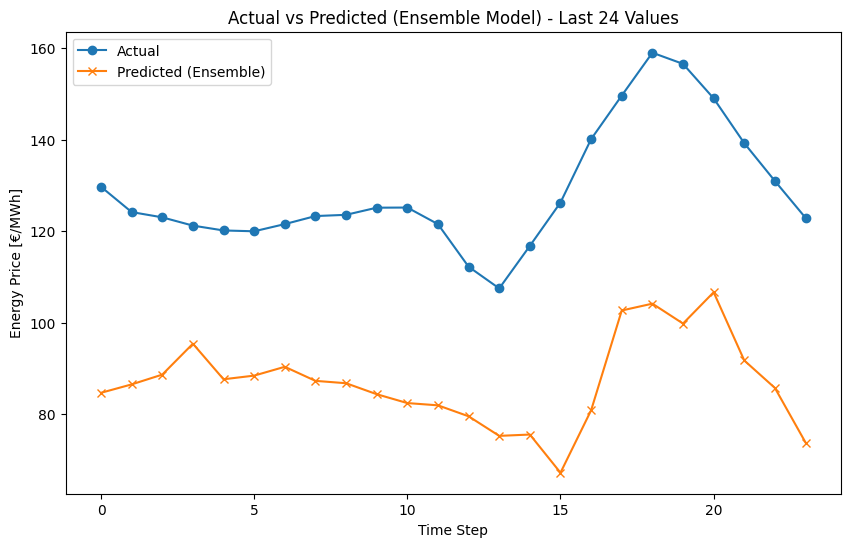

In [ ]:
# Plot predictions vs actual values for the last 24 values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[-24:], label="Actual", marker="o")
plt.plot(ensemble_pred[-24:], label="Predicted (Ensemble)", marker="x")
plt.title("Actual vs Predicted (Ensemble Model) - Last 24 Values")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

# Random Forest Regressor

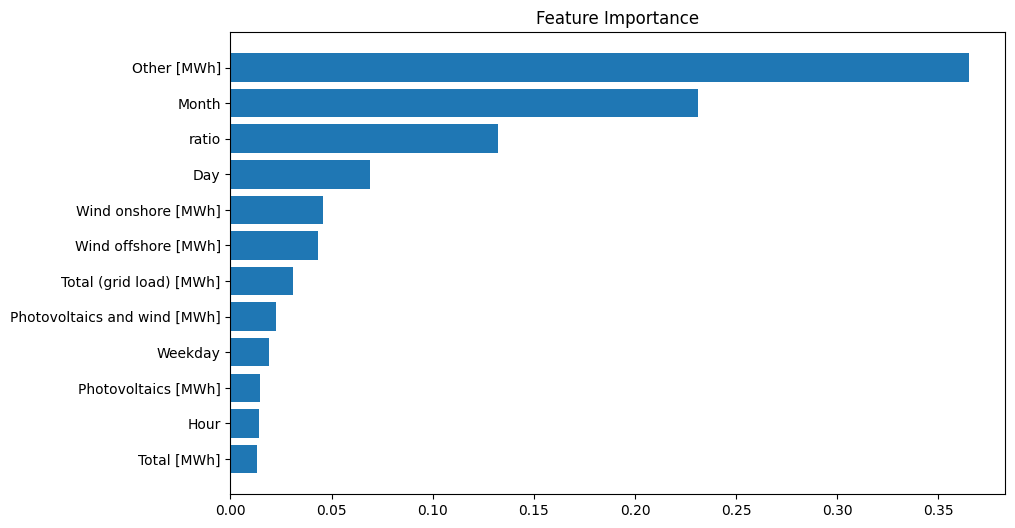

(22.38822164321637, 0.5794955357868845, 37.90743057931321)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

#df['End date'] = pd.to_datetime(df['End date'])
#df.drop(columns=['End date'], inplace=True)

# Features and target
X = df.drop(columns=['Germany/Luxembourg [€/MWh]'])
y = df['Germany/Luxembourg [€/MWh]']

# Split the dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train a Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# Select top N important features (e.g., top 5)
top_features = importance_df['Feature'].iloc[:5]
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Retrain the model with selected features
model.fit(X_train_selected, y_train)

# Make predictions
y_pred = model.predict(X_test_selected)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae, r2, rmse

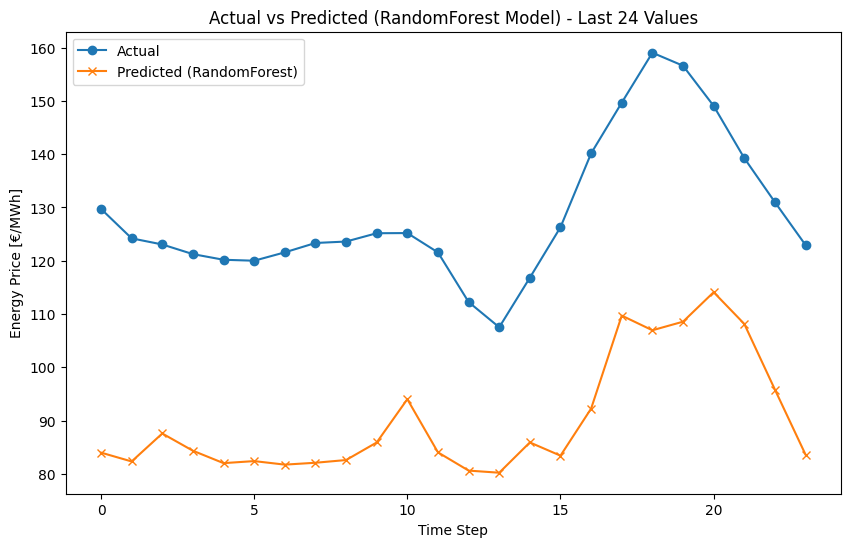

In [ ]:
# Plot predictions vs actual values for the last 24 values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[-24:], label="Actual", marker="o")
plt.plot(y_pred[-24:], label="Predicted (RandomForest)", marker="x")
plt.title("Actual vs Predicted (RandomForest Model) - Last 24 Values")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()


## Results of training the models without lagged features

#### 1. We have excluded GRUs in this experiment as it is inherently designed to capture long term historical dependencies in data. Thus, training a GRU without a sequence length would defy its functionality.

#### 2. The average MAE for all models combined has increased by approximately 122 percent and the R2 score has decreased by approximately 22 percent.

#### 3. The lack of lagged features show way higher MAE and RMSE scores than when the models are trained with unclean data. This proves that all these three models are better at handling noisy data and are somewhat robust towards outliers, but are inherently unable to capture and learn the historic relationship of the data.

#### 4. These results also prove that the energy prices of each day are highly dependent on the energy prices of the previous days in addition to the other features

# Test only last 24 values

#### In this run, instead of splitting the data as 80-20 for training and testing, we use the entire dataset for training and only use the last 24 hours for testing.

# CatBoost

0:	learn: 73.1842110	test: 18.2479627	best: 18.2479627 (0)	total: 11ms	remaining: 5.49s
100:	learn: 13.4559059	test: 3.7157063	best: 3.7066508 (96)	total: 887ms	remaining: 3.5s
200:	learn: 11.8391906	test: 3.5822047	best: 3.4604426 (140)	total: 1.79s	remaining: 2.66s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 3.460442559
bestIteration = 140

Shrink model to first 141 iterations.

Evaluation Metrics for CatBoost Model:
Root Mean Squared Error (RMSE): 3.4604
Mean Absolute Error (MAE): 2.7045
R-squared (R²): 0.9306


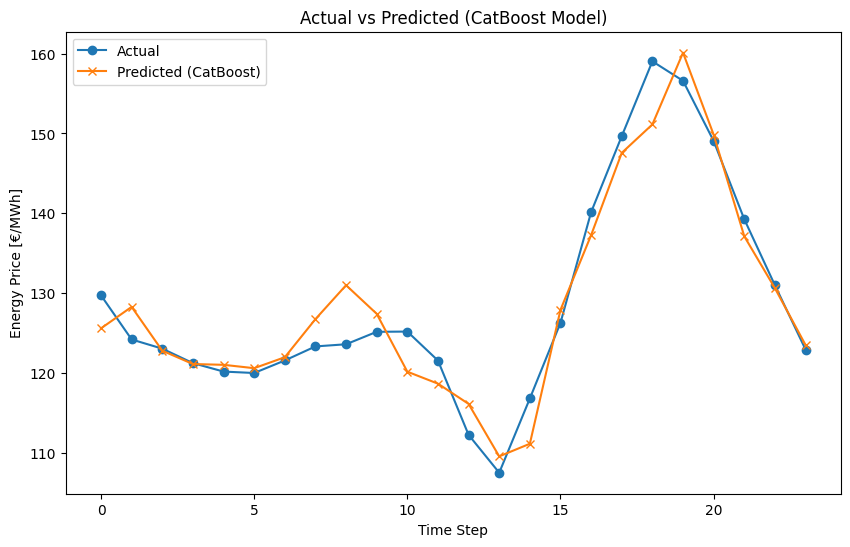

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to create lagged features
def create_lagged_features(data, target_col, lags):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    df = df.dropna()  # Drop rows with NaN values caused by lagging
    return df

# Load your dataset
target_col = 'Germany/Luxembourg [€/MWh]'
lags = 24  # Number of lagged features
data = create_lagged_features(df, target_col, lags)

# Features and target
X = data.drop(columns=[target_col], errors='ignore')  # Drop target and date columns
y = data[target_col]

# Split the dataset: all data except the last 24 rows for training, last 24 rows for testing
X_train, X_test = X.iloc[:-24], X.iloc[-24:]
y_train, y_test = y.iloc[:-24], y.iloc[-24:]

# Initialize CatBoost Regressor
catboost_model = CatBoostRegressor(
    iterations=500,         # Number of boosting iterations
    learning_rate=0.05, # Learning rate
    l2_leaf_reg=3,          # L2 regularization
    depth=4,                 # Depth of trees
    loss_function='RMSE',    # Loss function
    random_seed=42,
    verbose=100              # Print training progress every 100 iterations
)

# Train the CatBoost model
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, early_stopping_rounds=100)

# Make predictions
y_pred = catboost_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nEvaluation Metrics for CatBoost Model:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual", marker="o")
plt.plot(y_pred, label="Predicted (CatBoost)", marker="x")
plt.title("Actual vs Predicted (CatBoost Model)")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

# Random Forest


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_error, r2_score

#df['End date'] = pd.to_datetime(df['End date'])
#df.drop(columns=['End date'], inplace=True)

# Function to create lagged features
def create_lagged_features(data, target_col, lags):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    df = df.dropna()  # Drop rows with NaN values caused by lagging
    return df

# Load the dataset
target_col = 'Germany/Luxembourg [€/MWh]'
lags = 24  # Number of lagged features
data = create_lagged_features(df, target_col, lags)

# Features and target
X = data.drop(columns=[target_col], errors='ignore')  # Drop target and date columns
y = data[target_col]

n_test = 24
X_train, X_test = X.iloc[:-n_test], X.iloc[-n_test:]
y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=200, max_depth=10,random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae, r2, rmse

(2.6749597102381997, 0.9258484338087187, 3.5763411121152298)

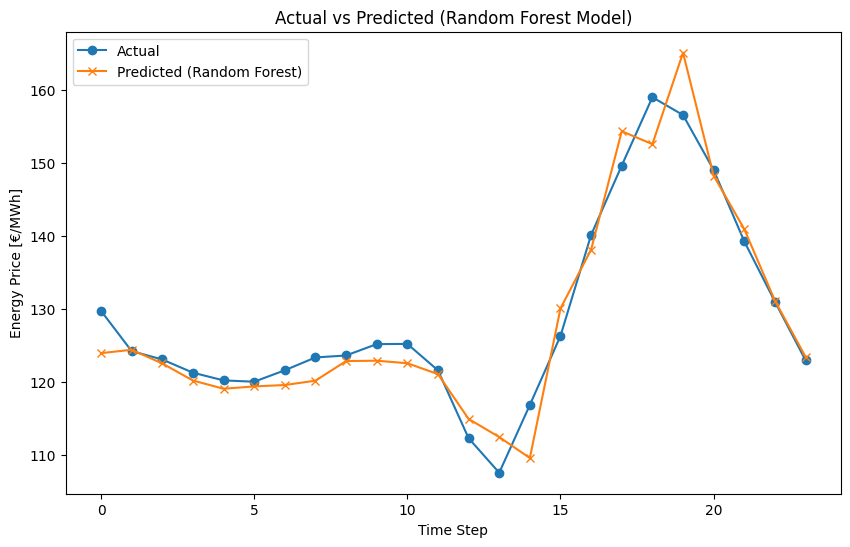

In [ ]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual", marker="o")
plt.plot(y_pred, label="Predicted (Random Forest)", marker="x")
plt.title("Actual vs Predicted (Random Forest Model)")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

# Ensemble Model


Evaluation Metrics for Ensemble Model:
Root Mean Squared Error (RMSE): 3.7691
Mean Absolute Error (MAE): 2.8852
R-squared (R²): 0.9176


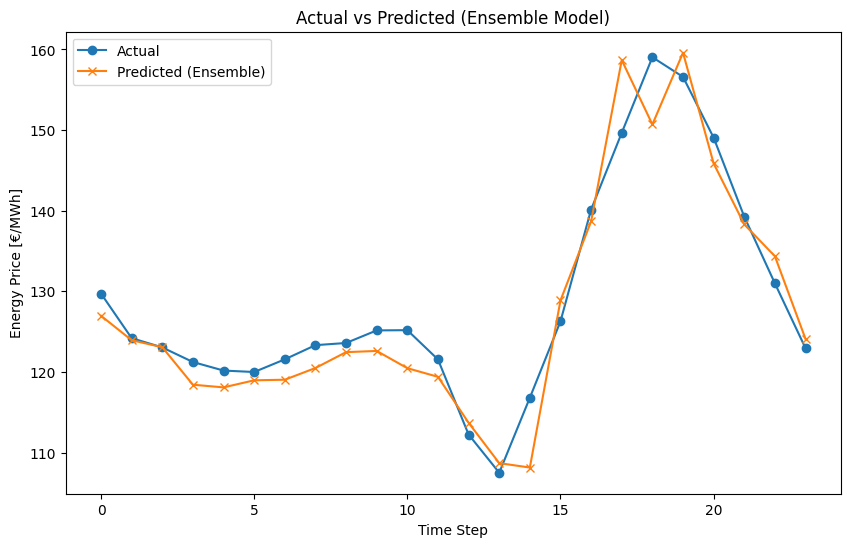

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Function to create lagged features
def create_lagged_features(data, target_col, lags):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    df = df.dropna()  # Drop rows with NaN values caused by lagging
    return df

# Load your dataset
target_col = 'Germany/Luxembourg [€/MWh]'
lags = 24  # Number of lagged features
data = create_lagged_features(df, target_col, lags)

# Features and target
X = data.drop(columns=[target_col])  # Drop target and date columns
y = data[target_col]

X.columns = X.columns.str.replace(r"[\[\]<]", "", regex=True).str.replace(" ", "_")

# Split the dataset: all data except the last 24 rows for training, last 24 rows for testing
X_train, X_test = X.iloc[:-24], X.iloc[-24:]
y_train, y_test = y.iloc[:-24], y.iloc[-24:]

# Initialize models
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)

# Train Random Forest model
rf_model.fit(X_train, y_train)
# Train XGBoost model
xgb_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# Combine predictions using a simple average
ensemble_pred = (rf_pred + xgb_pred) / 2

# Evaluate the ensemble model
rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
mae = mean_absolute_error(y_test, ensemble_pred)
r2 = r2_score(y_test, ensemble_pred)

print("\nEvaluation Metrics for Ensemble Model:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual", marker="o")
plt.plot(ensemble_pred, label="Predicted (Ensemble)", marker="x")
plt.title("Actual vs Predicted (Ensemble Model)")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

# GRU

Epoch 1/15
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - loss: 0.0136 - val_loss: 0.0023
Epoch 2/15
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 3/15
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 4/15
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 5/15
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 6/15
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 7/15
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 8/15
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 9/15
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 10/15
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 11/15
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 12

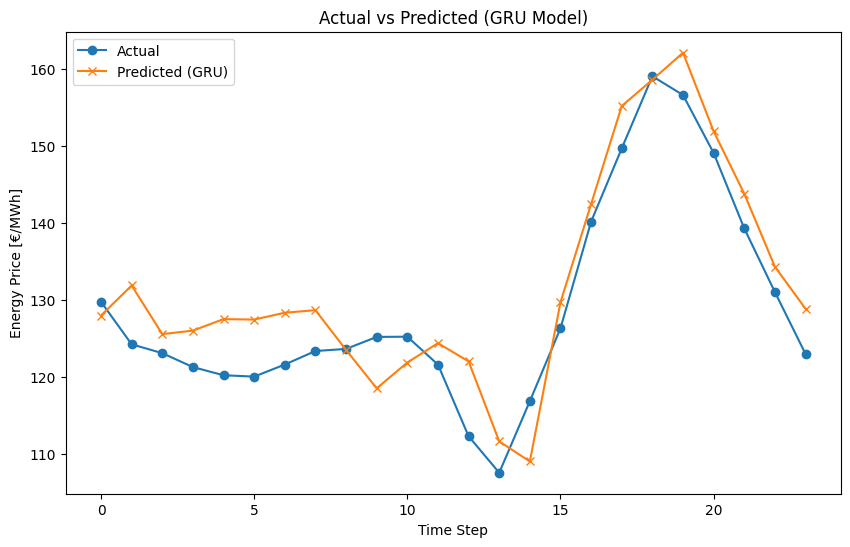

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

# Load your dataset
target_col = 'Germany/Luxembourg [€/MWh]'
data = df[[target_col]].values  # Select the target column as a numpy array

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Define sequence length
sequence_length = 24  # Use the past 24 timesteps to predict the next one

# Prepare data for GRU
def prepare_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])  # Past sequence_length timesteps
        y.append(data[i + sequence_length])   # The next timestep
    return np.array(X), np.array(y)

X, y = prepare_sequences(data_scaled, sequence_length)

# Split into training and testing sets
train_size = len(X) - 24
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build GRU model
model = Sequential([
    GRU(64, input_shape=(sequence_length, 1), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the GRU model
history = model.fit(X_train, y_train, epochs=15, batch_size=16, validation_split=0.2, verbose=1)

# Make predictions
gru_pred = model.predict(X_test)

# Rescale predictions and actual values back to original scale
y_test_rescaled = scaler.inverse_transform(y_test)
gru_pred_rescaled = scaler.inverse_transform(gru_pred)

# Evaluate the GRU model
rmse = np.sqrt(mean_squared_error(y_test_rescaled, gru_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, gru_pred_rescaled)
r2 = r2_score(y_test_rescaled, gru_pred_rescaled)

print("\nEvaluation Metrics for GRU Model:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="Actual", marker="o")
plt.plot(gru_pred_rescaled, label="Predicted (GRU)", marker="x")
plt.title("Actual vs Predicted (GRU Model)")
plt.xlabel("Time Step")
plt.ylabel("Energy Price [€/MWh]")
plt.legend()
plt.show()

## Results of testing the models with last 24 hours

#### 1. The RMSE and MAE values for all the models have drastically decreased whereas the R2 scores are almost the same as the previous results.
#### 2. GRU shows a sharp decrease in MAE and RMSE values, but its R2 score also decreases which suggests that the model is unable to generalise well on a small testing data.
#### 3.The significantly lower errors of CatBoost, RFR and Ensemble model are quite misleading as their R2 scores have not changed much.
#### 4.In all the line grphs we see that most of the predicted values are almost the same as the actual values, which is also another indication of overfitting and the extremely low error metrics.
#### 5. This is because the models have very less variance to account for due to the small test data and seem to have overfitted due to a very large training data.

# Discussion of Results

#### From the above results we can observe that CatBoost consistently performs better in all conditions since it can handle a combination of categorical and continuous variables well. It is robust to outliers and noise but requires lagged features to maintain a good performance as it is inherently incapable to handling autoregressive relationships in data. RFR, while showing a decent performance by itself, significantly improves when combined with XGBoost in the Ensemble model as these two models work in unison to minimize the error of prediction while learning the data pattern well. GRUs underperform in the absence of data cleaning and insufficient historical data as they rely heavily on sequential dependencies and long-term memory retention. Without well-preprocessed data and adequate historical context, GRUs struggle to capture and learn meaningful temporal patterns, leading to suboptimal performance.